# AMÉLIORER LE PRODUIT IA DE VOTRE START-UP

<img src="logoAvisRestau.png" alt="logoAvisRestau" width="300" class="center"/>

# Préambule

## 0.1) Projet de l'entreprise

Notre entreprise "Avis Restau" souhaite développer une nouvelle fonctionnalité de collaboration :

L'**utilisateur** pourra ainsi :

- poster des avis sous forme de **commentaires**
- poster des **photos** prises dans le restaurant

La mise à disposition de ces nouvelles features présente des opportunités pour l'entreprise qui pourra exploiter ces données pour mieux comprendre ses utilisateurs. L'**entreprise** pourra :

- **détecter** les sujets d’**insatisfaction** présents dans les commentaires postés sur la plateforme.
- **labelliser** automatiquement les **photos** postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

Le projet : Étude **préliminaire** de ces deux fonctionnalités

## 0.2) Options du Notebook

L'option `deletePhotos` régule l'activation ou non d'un code permettant d'effacer une grande majorité des photos téléchargées sur *Yelp*. Par défaut celle-ci n'est pas activée.

In [1]:
# option to delete most of Yelp dataset photos
deleteMostPhotos = False

# PARTIE I - ANALYSER LES COMMENTAIRES NÉGATIFS POUR DÉTECTER LES DIFFÉRENTS SUJETS D’INSATISFACTION

# NLP - 0) Méthode

L'objectif **final** est de détecter les sujets de mécontentement dans les avis qui seront postés sur **Avis Restau**. Le but ici n'est pas de réaliser ce projet entièrement **mais de tester sa faisabilité**. Pour cela nous avons la chance de disposer d'un jeu de données existant disponible sur la plateforme **Yelp**. 

Nous réaliserons donc notre études préliminaire sur ce dataset :
- Nous réaliserons les étapes préalables à l'entraînement d'une algorithme de détection de sujets :
    - sélectionner quelques milliers de **commentaires négatifs**
    - **pré-traiter** ces données :
        - mettre en minuscule,
        - tokeniser,
        - normaliser les mots via une lemmatisation,
        - etc.
    - création du **dictionnaire** et représentation de nos reviews en vecteurs **bag-of-words**
    - adapter la **pondération** des mots grâce à un **TF-IDF**
- Nous testerons alors la faisabilité sur ce petit échantillons :
    - utiliser une **technique de réduction de dimension** de type **topic-modeling** pour extraire nos sujets d'insatisfaction sous-jacents de notre corpus. Nous utiliserons ici le `Latent Dirichlet Allocation (LDA)`
    - évaluer notre réduction afin de choisir le bon hyperparamètre `num_topics`
- Enfin nous tâcherons de visualiser nos topics afin d'en détecter les mots-clés. Pour cela nous utiliserons 2 librairies :
    - `wordcloud`
    - `pyLDAvis`

# NLP - 1) Imports

In [2]:
# data manipulation
import pandas as pd  # to manipulate the dataset with dataframes
import numpy as np  # for statistics and calculations

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# counter
from collections import Counter

# pipeline
from sklearn.pipeline import Pipeline 

# custom functions
import myFunctions as mf
%load_ext autoreload

%autoreload 2

# for memory management
import gc

# nlp with nltk
import nltk
# stopwords management
from nltk.corpus import stopwords
nltk.download('stopwords')
# nlp with spacy
import spacy
nlp = spacy.load("en_core_web_sm")

# LDA
from gensim.models.ldamodel import LdaModel

# wordcloud
from wordcloud import WordCloud

# pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# file and directory management
import os
# to make saves
from joblib import dump, load  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# NLP - 2) Nos données

L'entreprise ne possède pas encore de données permettant le développement du projet. L'idée est alors d'utiliser un dataset existant : YELP

Le dataset qui nous intéresse est `yelp_academic_dataset_review.json`
 qui contient entre autres les commentaires reçus sur la plateforme YELP. Commençons par charger quelques lignes :

In [3]:
# load first 10 rows of "yelp_academic_dataset_review.json"

# use options of read_son function to adapt to the json file
# Yelp documentation : "Each file is composed of a single object type, one JSON-object per-line"
# --> use `lines`=True and `orient`="records" 

with open("dataYelp/yelp_academic_dataset_review.json", mode="r", encoding="utf8") as f:
    rev10 = pd.read_json(
        path_or_buf=f, 
        orient="records", 
        lines=True, 
        nrows=10
    )

In [4]:
rev10

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
5  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   
6  6AxgBCNX_PNTOxmbRSwcKQ  r3zeYsv1XFBRA4dJpL78cw  gmjsEdUsKpj9Xxu6pdjH0g   
7  _ZeMknuYdlQcUqng_Im3yg  yfFzsLmaWF2d4Sr0UNbBgg  LHSTtnW3YHCeUkRDGyJOyw   
8  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
9  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   
5      1       1      2     1   
6      5       0      2     0   
7      5       2      0     0   
8      3       1      1     0   
9      3       0      0     0   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15  
5  I am a long term frequent customer of this est... 2015-09-23 23:10:31  
6  Loved this tour! I grabbed a groupon and the p... 2015-01-03 23:21:18  
7  Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16  
8  This easter instead of going to Lopez Lake we ... 2016-03-30 22:46:33  
9  Had a party of 6 here for hibachi. Our waitres... 2016-07-25 07:31:06

Nous cherchons ici à détecter les différents sujets d'insatisfaction. La colonne qui nous intéresse est donc seulement `text`, et seulement pour des valeurs de `stars` basses.

Le souci est que nous ne sommes pas sûr que les commentaires concernent des restaurants ... Chargeons également les premières lignes de `yelp_academic_dataset_business.json` :

In [5]:
# load first 10 rows of "yelp_academic_dataset_business.json"

# use options of read_son function to adapt to the json file
# Yelp documentation : "Each file is composed of a single object type, one JSON-object per-line"
# --> use `lines`=True and `orient`="records" 

with open("dataYelp/yelp_academic_dataset_business.json", mode="r", encoding="utf8") as f:
    bus10 = pd.read_json(
        path_or_buf=f, 
        orient="records", 
        lines=True, 
        nrows=10
    )

In [6]:
bus10

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
5  CF33F8-E6oudUQ46HnavjQ            Sonic Drive-In   
6  n_0UpQx1hsNbnPUSlodU8w           Famous Footwear   
7  qkRM_2X51Yqxk3btlwAQIg            Temple Beth-El   
8  k0hlBqXX-Bt0vf1op7Jr1w     Tsevi's Pub And Grill   
9  bBDDEgkFA1Otx9Lfe7BZUQ            Sonic Drive-In   

                                      address            city state  \
0                      1616 Chapala St, Ste 2   Santa Barbara    CA   
1             87 Grasso Plaza Shopping Center          Affton    MO   
2                        5255 E Broadway Blvd          Tucson    AZ   
3                                 935 Race St    Philadelphia    PA   
4                               101 Walnut St      Green Lane    PA   
5                               615 S Main St    Ashland City    TN   
6  8522 Eager Road, Dierbergs Brentwood Point       Brentwood    MO   
7                          400 Pasadena Ave S  St. Petersburg    FL   
8                           8025 Mackenzie Rd          Affton    MO   
9                         2312 Dickerson Pike       Nashville    TN   

   postal_code   latitude   longitude  stars  review_count  is_open  \
0        93101  34.426679 -119.711197    5.0             7        0   
1        63123  38.551126  -90.335695    3.0            15        1   
2        85711  32.223236 -110.880452    3.5            22        0   
3        19107  39.955505  -75.155564    4.0            80        1   
4        18054  40.338183  -75.471659    4.5            13        1   
5        37015  36.269593  -87.058943    2.0             6        1   
6        63144  38.627695  -90.340465    2.5            13        1   
7        33707  27.766590  -82.732983    3.5             5        1   
8        63123  38.565165  -90.321087    3.0            19        0   
9        37207  36.208102  -86.768170    1.5            10        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   
5  {'BusinessParking': 'None', 'BusinessAcceptsCr...   
6  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
7                                               None   
8  {'Caters': 'True', 'Alcohol': 'u'full_bar'', '...   
9  {'RestaurantsAttire': ''casual'', 'Restaurants...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   
5  Burgers, Fast Food, Sandwiches, Food, Ice Crea...   
6  Sporting Goods, Fashion, Shoe Stores, Shopping...   
7                Synagogues, Religious Organizations   
8  Pubs, Restaurants, Italian, Bars, American (Tr...   
9  Ice Cream & Frozen Yogurt, Fast Food, Burgers,...   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...  
5  {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...  
6  {'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...  
7  {'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...  
8                                               None  
9  {'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...

Nous retrouvons `business_id` qui est déjà présente dans le dataset des `reviews`. Et nous avons également une colonne `categorie` qui nous permettra de sélectionner **seulement des restaurants**.

# NLP - 3) Pré-traitement

## NLP - 3.1) Sélectionner quelques milliers de commentaires négatifs

Nous allons de nouveau charger le dataset :
- en entier :
    - Mais le dataset fait plus de 5 Go...
    - Pour contourner le problème nous utiliserons l'option `chunksize` de la fonction `read_json`, qui retournera non pas un dataframe unique mais un itérateur contenant des dataframes avec le nombre de lignes demandées
- filtrer sur les notes `stars`
- l'échantillonner pour ne conserver que 10000 commentaires négatifs

Nous utiliserons également le dataset `business` afin de sélectionner des `business_id` correspondant à des **restaurants** :

In [7]:
%%time
# load all "yelp_academic_dataset_review.json" and filter on "stars"=1
rev = mf.loadReviews(
    revPath="dataYelp/yelp_academic_dataset_review.json", 
    busPath="dataYelp/yelp_academic_dataset_business.json",
    revSize=10000, 
    revStars=[1,2])


CPU times: total: 1.2 s
Wall time: 6.72 s


Voici donc notre échantillon de commentaires négatifs :

In [8]:
rev = rev.to_frame()
rev

text
1947    I came here for lunch and was very disappointe...
5136    One star for really nice service + no wait (ca...
5803    Fried rice looks like brown rice about 2 1/4 i...
3459    I agree with some of the other commenters, the...
7301    I used the mobile app, the bill was for $31  a...
...                                                   ...
196744  Passing through Reno we stopped to get a bean ...
199082  For over an hour we were told we were next. Wa...
197735  If you're on a clock, this is not the place fo...
191503  Stopped in for dinner break as I work in the p...
191338  Ducked in to meet a local politician and talk ...

[10000 rows x 1 columns]

## NLP - 3.2) Exploration

Considérons tout d'abord l'ensemble de notre corpus :

In [9]:
# create a single corpus string
rawCorpus = "".join(rev["text"].values)

### NLP - 3.2.1) Première tokenisation

Procédons à une première tokenisation simple. Nous utiliserons seulement une expression régulière pour n'autoriser que les caractères a-z, A-Z et 0-9 :

In [10]:
# tokenize rawCorpus with custom function tokenize with regex r'\w+'
rawCorpusRawTokens = mf.tokenize(doc=rawCorpus, regex=r'\w+')

In [11]:
# display some random tokens
np.random.choice(rawCorpusRawTokens, size = 30)

array(['visited', 'Besh', 'likes', 'bartender', 'at', 'was', 'will',
       'are', 'having', 'apparently', 'when', 'I', 'time', 'and', 'not',
       'food', 'few', 'the', 'almost', 'magazine', 'other', 'to', 'take',
       'food', 'but', 'the', 'heard', 'another', 'waitress', 'and'],
      dtype='<U38')

### NLP - 3.2.2) Les mots les plus fréquents

Nous pouvons regarder les mots les plus fréquents dans notre corpus :

<Axes: xlabel='freq', ylabel='token'>

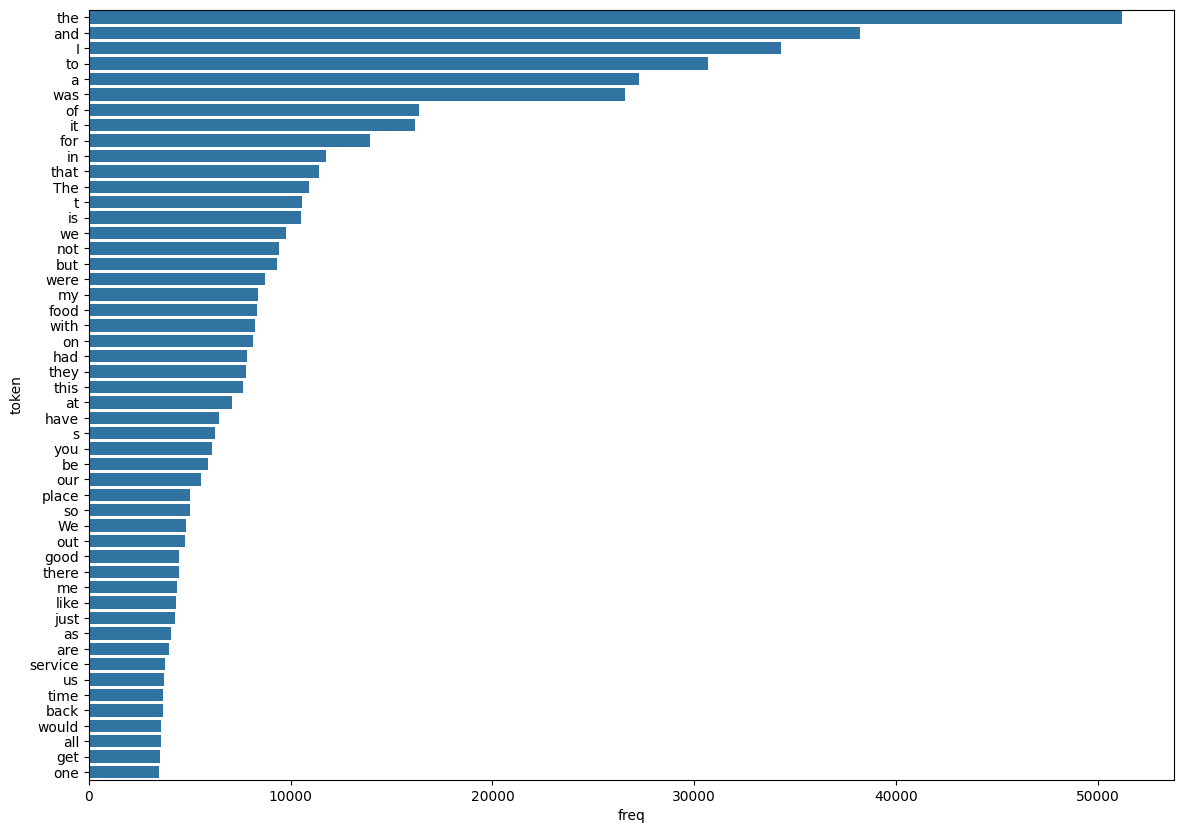

In [12]:
# use Counter function to find most common tokens
rawFreq = Counter(rawCorpusRawTokens)

# put the most frequent in a dataframe
N = 50
rawFreqDf = pd.DataFrame(rawFreq.most_common(N), columns=["token","freq"])

# plot
fig, ax = plt.subplots(1,1,figsize = (14,0.2*N))
sns.barplot(data=rawFreqDf, x="freq", y="token")

Nous avons ici un problème dit de **"mots-vides"**. Ces mots qui sont les plus fréquents ne nous apportent pas vraiment d'information et surtout ne permettent pas de caractériser un document par rapport aux autres...
<br> Essayons de les supprimer :

In [13]:
# create a set of stop-words
stop_words = set(stopwords.words('english'))
# remove them from our tokenized corpus
rawCorpusRawTokens = [token for token in rawCorpusRawTokens if token.lower() not in stop_words]

Regardons ce que cela donne maintenant :

<Axes: xlabel='freq', ylabel='token'>

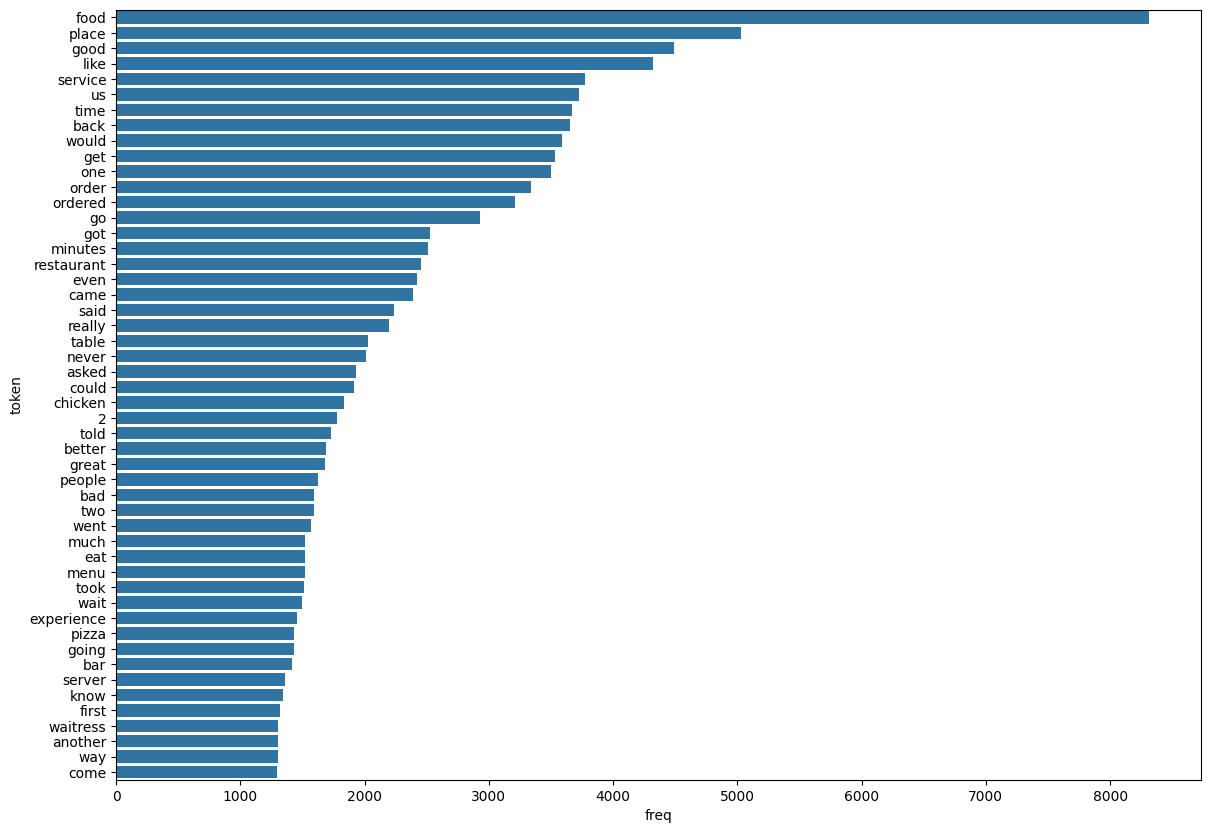

In [14]:
# use Counter function to find most common tokens
rawFreq = Counter(rawCorpusRawTokens)

# put the most frequent in a dataframe
N = 50
rawFreqDf = pd.DataFrame(rawFreq.most_common(N), columns=["token","freq"])

# plot
fig, ax = plt.subplots(1,1,figsize = (14,0.2*N))
sns.barplot(data=rawFreqDf, x="freq", y="token")

Nous avons toujours un problème de *mots-vides*, mais ceux-ci sont maintenant **caractéristiques du problème que nous essayons de résoudre** :

Il s'agit d'un corpus de commentaires de restaurants. Si nous souhaitons rechercher les sujets d'insatisfaction, nous devons faire attention aux mots communs du champs lexical du restaurant :

In [15]:
# create a list of custom stopwords
customStopWords = [
    "restaurant",
    # "food",
    "diner",
    "dinner,"
    "bistro",
    "cafe",
    "dining",
    "hotel",
    "lunch",
    "place"
]

Il faudra peut-être également prendre garde au **noms de plat** comme *pizza* ou *chicken*...

### NLP - 3.2.3) Les mots avec des caractères répétés

Notre corpus est composé de commentaires, c'est-à-dire des documents non littéraires, aussi il nous faut également prendre garde aux mots contenant plusieurs lettres répétées (souvent utilisés pour mettre l'accent sur ce mot).

Regardons s'il y en a :

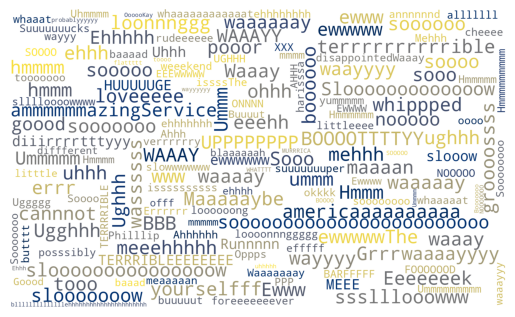

In [16]:
# use custom function findMultipleChars to detect word with repeated chars 
repeatedCharsWords = mf.findMultipleChars(rawCorpus,3)
# use wordcloud to look at them in a visualisation
# first select n random words
nWordsToPLot = 250
repeatedCharsWords = np.random.choice(repeatedCharsWords, size=nWordsToPLot, replace=False)
# put our list in a dict (for wordCloud compatibility)
repeatedCharsWords = {word : 1 for word in repeatedCharsWords}
# create our wordcloud object with max_words = nWordsToPLot
wc = WordCloud(
        width=2000,
        height=1200,
        max_words=nWordsToPLot,
        max_font_size=75,
        min_font_size=20,
        background_color="white",
        colormap="cividis"
        )
# fit our wordcloud
repeatedCharsWordCloud = wc.fit_words(repeatedCharsWords)

# plot using matplotlib imshow
plt.imshow(repeatedCharsWordCloud)
# repeatedCharsWordCloud.to_file("repeatedCharsWordCloud.jpg")

# no axis
plt.axis(False)

plt.show()

Ces mots perturberaient notre réduction de dimension s'il ne sont pas traités.

Passons maintenant au nettoyage à proprement parler :

## NLP - 3.3) Cleaning

Afin de rendre cette partie visuelle, nous allons ajouter une colonne après chaque grande étape. 

### NLP - 3.3.1) Passer en minuscules

Commençons par passer tous les commentaires en **minuscules** :

In [17]:
# use custom function myLower put our text column to lowercase
rev["lower"] = mf.myLower(rev["text"])

In [18]:
rev

text  \
1947    I came here for lunch and was very disappointe...   
5136    One star for really nice service + no wait (ca...   
5803    Fried rice looks like brown rice about 2 1/4 i...   
3459    I agree with some of the other commenters, the...   
7301    I used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  Passing through Reno we stopped to get a bean ...   
199082  For over an hour we were told we were next. Wa...   
197735  If you're on a clock, this is not the place fo...   
191503  Stopped in for dinner break as I work in the p...   
191338  Ducked in to meet a local politician and talk ...   

                                                    lower  
1947    i came here for lunch and was very disappointe...  
5136    one star for really nice service + no wait (ca...  
5803    fried rice looks like brown rice about 2 1/4 i...  
3459    i agree with some of the other commenters, the...  
7301    i used the mobile app, the bill was for $31  a...  
...                                                   ...  
196744  passing through reno we stopped to get a bean ...  
199082  for over an hour we were told we were next. wa...  
197735  if you're on a clock, this is not the place fo...  
191503  stopped in for dinner break as i work in the p...  
191338  ducked in to meet a local politician and talk ...  

[10000 rows x 2 columns]

### NLP - 3.3.2) Retirer les url

Nous remarquons que de certains commentaires possèdent des **liens de site internet**.

Nous allons les remplacer par des espaces :

In [19]:
# use custom function removeEscapeSequences to replace escape sequences (like '\n') with espapes ' '
rev["withoutURL"] = mf.removeURL(rev["lower"])

In [20]:
rev

text  \
1947    I came here for lunch and was very disappointe...   
5136    One star for really nice service + no wait (ca...   
5803    Fried rice looks like brown rice about 2 1/4 i...   
3459    I agree with some of the other commenters, the...   
7301    I used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  Passing through Reno we stopped to get a bean ...   
199082  For over an hour we were told we were next. Wa...   
197735  If you're on a clock, this is not the place fo...   
191503  Stopped in for dinner break as I work in the p...   
191338  Ducked in to meet a local politician and talk ...   

                                                    lower  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                               withoutURL  
1947    i came here for lunch and was very disappointe...  
5136    one star for really nice service + no wait (ca...  
5803    fried rice looks like brown rice about 2 1/4 i...  
3459    i agree with some of the other commenters, the...  
7301    i used the mobile app, the bill was for $31  a...  
...                                                   ...  
196744  passing through reno we stopped to get a bean ...  
199082  for over an hour we were told we were next. wa...  
197735  if you're on a clock, this is not the place fo...  
191503  stopped in for dinner break as i work in the p...  
191338  ducked in to meet a local politician and talk ...  

[10000 rows x 3 columns]

### NLP - 3.3.3) Retirer les séquences d'échappement

Nous remarquons que de certains commentaires possèdent des **séquences d'échappement** (escape sequences), comme :
- `\n` : nouvelle ligne
- `\r` : retour charriot
- etc.

Nous allons les remplacer par des espaces :

In [21]:
# use custom function removeEscapeSequences to replace escape sequences (like '\n') with espapes ' '
rev["withoutEscSeq"] = mf.removeEscapeSequences(rev["withoutURL"])

In [22]:
rev

text  \
1947    I came here for lunch and was very disappointe...   
5136    One star for really nice service + no wait (ca...   
5803    Fried rice looks like brown rice about 2 1/4 i...   
3459    I agree with some of the other commenters, the...   
7301    I used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  Passing through Reno we stopped to get a bean ...   
199082  For over an hour we were told we were next. Wa...   
197735  If you're on a clock, this is not the place fo...   
191503  Stopped in for dinner break as I work in the p...   
191338  Ducked in to meet a local politician and talk ...   

                                                    lower  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                               withoutURL  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                            withoutEscSeq  
1947    i came here for lunch and was very disappointe...  
5136    one star for really nice service + no wait (ca...  
5803    fried rice looks like brown rice about 2 1/4 i...  
3459    i agree with some of the other commenters, the...  
7301    i used the mobile app, the bill was for $31  a...  
...                                                   ...  
196744  passing through reno we stopped to get a bean ...  
199082  for over an hour we were told we were next. wa...  
197735  if you're on a clock, this is not the place fo...  
191503  stopped in for dinner break as i work in the p...  
191338  ducked in to meet a local politician and talk ...  

[10000 rows x 4 columns]

### NLP - 3.3.4) Corriger les mots avec des lettres répétées

Comme vu précédemment, corrigeons les mots de type *"soooooooooo"*. Pour cela nous allons :
- pour chaque commentaire
- détecter les mots concernés (contenant des lettres répétées 3x au moins)
- créer différentes corrections possibles :
    - en le laisser tel quel
    - en ne gardant qu'une fois la lettre
    - en la gardant 2 fois (permet de corriger convenablement *"realllllllly"* par exemple)
- tester ces possiblités (nous utiliserons la base de données lexicales `WordNet`)
- garder la première correction qui appartient bien à la base.

In [23]:
# use custom function correctRepeatedChars_series to correct word containing repeated chars
rev["withoutDupl"] = mf.correctRepeatedChars_series(rev["withoutEscSeq"])

Regardons ce que cela donne, mais avant cela filtrons notre dataframe sur les *reviews* contenant des caractères répétés :

In [24]:
# create a mask for docs containing words with characters repeated more than 3 times
repeatedCharsListsSeries = rev["withoutEscSeq"].apply(lambda x : mf.findMultipleChars(x,3))
mask = repeatedCharsListsSeries.apply(lambda x : len(x)!=0)

# display rev filtered with this mask
rev.loc[mask]

text  \
7541    I was beyond excited to find that a new "Mom a...   
4952    Wednesday night 8/24/16. Talk about bad.. Wow....   
9722    im a frequent backyard bowls customer and usua...   
5312    After reading the reviews we decided to try it...   
3268    Over priced and over hyped.  We were visiting ...   
...                                                   ...   
194833  We went there because the web site said they h...   
190009  I work nearby, so really wanted this place to ...   
190168  tried them out for the first time at the night...   
194904  I have mixed feelings giving the Brew Brothers...   
193632  It is sooooo slow, I waited at least 40min for...   

                                                    lower  \
7541    i was beyond excited to find that a new "mom a...   
4952    wednesday night 8/24/16. talk about bad.. wow....   
9722    im a frequent backyard bowls customer and usua...   
5312    after reading the reviews we decided to try it...   
3268    over priced and over hyped.  we were visiting ...   
...                                                   ...   
194833  we went there because the web site said they h...   
190009  i work nearby, so really wanted this place to ...   
190168  tried them out for the first time at the night...   
194904  i have mixed feelings giving the brew brothers...   
193632  it is sooooo slow, i waited at least 40min for...   

                                               withoutURL  \
7541    i was beyond excited to find that a new "mom a...   
4952    wednesday night 8/24/16. talk about bad.. wow....   
9722    im a frequent backyard bowls customer and usua...   
5312    after reading the reviews we decided to try it...   
3268    over priced and over hyped.  we were visiting ...   
...                                                   ...   
194833  we went there because the web site said they h...   
190009  i work nearby, so really wanted this place to ...   
190168  tried them out for the first time at the night...   
194904  i have mixed feelings giving the brew brothers...   
193632  it is sooooo slow, i waited at least 40min for...   

                                            withoutEscSeq  \
7541    i was beyond excited to find that a new "mom a...   
4952    wednesday night 8/24/16. talk about bad.. wow....   
9722    im a frequent backyard bowls customer and usua...   
5312    after reading the reviews we decided to try it...   
3268    over priced and over hyped.  we were visiting ...   
...                                                   ...   
194833  we went there because the web site said they h...   
190009  i work nearby, so really wanted this place to ...   
190168  tried them out for the first time at the night...   
194904  i have mixed feelings giving the brew brothers...   
193632  it is sooooo slow, i waited at least 40min for...   

                                              withoutDupl  
7541    i was beyond excited to find that a new "mom a...  
4952    wednesday night 8/24/16. talk about bad.. wow....  
9722    im a frequent backyard bowls customer and usua...  
5312    after reading the reviews we decided to try it...  
3268    over priced and over hyped.  we were visiting ...  
...                                                   ...  
194833  we went there because the web site said they h...  
190009  i work nearby, so really wanted this place to ...  
190168  tried them out for the first time at the night...  
194904  i have mixed feelings giving the brew brothers...  
193632  it is so slow, i waited at least 40min for my ...  

[286 rows x 5 columns]

### NLP - 3.3.5) Prétraitement plus large : tokenisation, stopwords, lemmatisation, etc.

Nous pouvons maintenant passer au nettoyage plus large :
- retirer les **ponctuations**
- retirer les **stopwords**
- retirer les **nombres** (*9*) et les nombres écrits en lettres (*nine*)
- normaliser les mots par **lemmatisation**
- filtrer sur certains **POS** (Part-of-Speech) tags

Nous en profiterons également pour retirer les "mots-vides" spécifiques au projet : **customStopWords** :

In [25]:
print(customStopWords)

['restaurant', 'diner', 'dinner,bistro', 'cafe', 'dining', 'hotel', 'lunch', 'place']


Nous créerons 2 colonnes : une en format texte et une **tokenisée** :

In [26]:
%%time
# use custom function cleanText to remove punctuations, stopwords, numbers, number-likes,  customStopWords and 
textClean, tokensClean = mf.cleanText(rev["withoutDupl"], customStopWords)

rev["textClean"] = textClean
rev["tokensClean"] = tokensClean

# print(freq.most_common(100))
# print("******************************")
# print(freq.most_common()[-100:])

CPU times: total: 1min 15s
Wall time: 2min 27s


In [27]:
rev

text  \
1947    I came here for lunch and was very disappointe...   
5136    One star for really nice service + no wait (ca...   
5803    Fried rice looks like brown rice about 2 1/4 i...   
3459    I agree with some of the other commenters, the...   
7301    I used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  Passing through Reno we stopped to get a bean ...   
199082  For over an hour we were told we were next. Wa...   
197735  If you're on a clock, this is not the place fo...   
191503  Stopped in for dinner break as I work in the p...   
191338  Ducked in to meet a local politician and talk ...   

                                                    lower  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                               withoutURL  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                            withoutEscSeq  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                              withoutDupl  \
1947    i came here for lunch and was very disappointe...   
5136    one star for really nice service + no wait (ca...   
5803    fried rice looks like brown rice about 2 1/4 i...   
3459    i agree with some of the other commenters, the...   
7301    i used the mobile app, the bill was for $31  a...   
...                                                   ...   
196744  passing through reno we stopped to get a bean ...   
199082  for over an hour we were told we were next. wa...   
197735  if you're on a clock, this is not the place fo...   
191503  stopped in for dinner break as i work in the p...   
191338  ducked in to meet a local politician and talk ...   

                                                textClean  \
1947    disappointed bland expensive quality food luke...   
5136    star nice service wait hour bad meal grit mass...   
5803    rice brown rice chunk egg vegtible water gun s...   
3459    commenter okay worth hype food good appetizer ...   
7301    mobile app bill friend store order card time i...   
...                   

Aparté - Exporter le dataframe des reviews :

In [28]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/rev"):
    os.mkdir("mySaves/rev")

In [29]:
%%time
# if no files in directory, save
if "rev.joblib" not in os.listdir("mySaves/rev") :
    # save
    dump(rev, "mySaves/rev/rev.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


## NLP - 3.4) Création dictionnaire et vecteur de Bag of Words

Maintenant que le nettoyage est réalisé, nous pouvons représenter notre corpus de façon numérique en attribuant à chaque document un vecteur de type **Bag-of-Words**. Nous allons :
- Commencer par créer un dictionnaire `gensim`
- Nota :  la fonction créée permet d'appliquer un filtre de fréquence sur le dictionnaire, aussi bien pour les mots rares que pour les mots les plus courants. **Pour l'instant nous n'appliquerons pas de filtres fréquence**

In [30]:
# use custom function makeDictionaryAndFilter to create a gensim dictionary
# no filtering
dictionary = mf.makeDictionaryAndFilter(
    rev["tokensClean"], 
    no_below=0, 
    no_above=1.0
)

In [31]:
len(dictionary)

13112

In [32]:
# use custom function makeBOW to create a vector of gensim bag-of-words
bow_vector = mf.makeBOW(
    tokensSeries=rev["tokensClean"],
    dictionary=dictionary
)

## NLP - 3.5) TF-IDF

$TF = N_{word,doc}$

Nous n'avons pour l'instant pas réalisé de filtre de fréquence sur les mots de notre dictionnaire, mais nous allons tout de même utiliser la fréquence des mots (à l'échelle des documents **et à l'échelle du corpus**) afin de réduire l'impact des mots trop fréquent : En effet un mot présent dans tous les document n'apportera que peu d'information par rapport aux mots plus rares pour différencier les documents.

Nous allons donc appliquer une **pondération** à chaque mot en utilisant le *TF-IDF* (*Term Frequency - Inverse Document Frequency*) :
$tfidf = TermFrequency \times InverseDocumentFrequency$<br>
- Il existe plusieurs manière de calculer $TF$, ici nous prendrons le **nombre d'occurrences du mot dans le document**
- Pour $IDF$, il y aussi plusieurs manières, nous utiliserons ici la formule suivante : $IDF = log_{2}(\frac{N_{docs}}{DF})$
  <br>(le log permet d'atténuer l'impact des mots présents dans vraiment peu de documents)

Une **normalisation *l2*** est enfin appliquée à chaque vecteur document.


In [33]:
# use custom function applyTFIDF on our corpus
tfidf_vector = mf.makeTFIDF(
    tokensSeries=rev["tokensClean"],
    dictionary = dictionary,
    smartirs='nfc'
)

## NLP - 3.6) Pré-traitement - pipeline

Avant de passer au test de faisabilité avec le `LDA`, nous allons intégrer toutes les étapes précédentes de preprocessing au sein d'un **pipeline** `Scikit Learn`. Ainsi, et dans le cadre de la poursuite éventuelle du projet, il nous sera **plus aisé de travailler sur le développement du modèle de détection** (exemples : intégrer ce pipeline à une recherche d'hyperparamètres sur grille, comparer `LDA` à d'autres modèles, etc.)

Afin de réaliser cela nous avons :
- utilisé **nos différentes fonctions** pour créer nos propres `transformer`s `Scikit Learn`, en les intégrant à des **classes**
- utilisé les classes `sklearn.base.TransformerMixin` et `sklearn.base.BaseEstimator` chacune comme **classe "parent"** afin de transmettre notamment les méthodes suivantes :
    - `get_params`
    - `set_params`
    - `fit_tranform`
- intégré dans chaque **classe "enfant"** les **méthodes manquantes** :
    - `__init__` (le constructeur pour instancifier notre `transformer` avec les différents paramètres à passer à la fonction)
    - `fit`
    - `transform`

Nous pouvons maintenant créer notre `pipeline` :

In [34]:
# create a pipeline with all our preprocessing steps

# store the path of the business json file
busPath="dataYelp/yelp_academic_dataset_business.json"
# store custom stopwords
customStopWords = [
    "restaurant",
    # "food",
    "diner",
    "dinner,"
    "bistro",
    "cafe",
    "dining",
    "hotel",
    "lunch",
    "place"
]

# create steps
reviewsSteps = [
    ("reviewsLoader", mf.reviewsLoader(busPath=busPath, revSize=10000, revStars=[1,2], random_state=16)), # loader for .json file
    ("lowerCasor", mf.lowerCasor()), # lowercase converter
    ("urlRemover", mf.urlRemover()), # URL remover
    ("escapeSequencesRemover", mf.escapeSequencesRemover()), # escape sequences remover
    ("repeatedCharsCorrector", mf.repeatedCharsCorrector()), # repeated characters corrector
    ("textCleaner", mf.textCleaner(customStopWords=customStopWords, posToKeep=["NOUN","ADJ"])), # text cleaner
    ("dictAndVectorMaker", mf.dictAndVectorMaker(no_below=0, no_above=1.0, smartirs = 'nfc', applyTfidf = True)), # dict and tfidf maker
    
]

# create scikit learn pipeline
generalReviewsPipe = Pipeline(steps=reviewsSteps, verbose=True)

In [35]:
%%time
# test our pipeline
tfidf_vector, dictionary = generalReviewsPipe.fit_transform("dataYelp/yelp_academic_dataset_review.json")

del generalReviewsPipe, reviewsSteps
gc.collect()

[Pipeline] ..... (step 1 of 7) Processing reviewsLoader, total=  15.6s
[Pipeline] ........ (step 2 of 7) Processing lowerCasor, total=   0.0s
[Pipeline] ........ (step 3 of 7) Processing urlRemover, total=   0.0s
[Pipeline]  (step 4 of 7) Processing escapeSequencesRemover, total=   0.1s
[Pipeline]  (step 5 of 7) Processing repeatedCharsCorrector, total=  19.1s
[Pipeline] ....... (step 6 of 7) Processing textCleaner, total= 3.0min
[Pipeline]  (step 7 of 7) Processing dictAndVectorMaker, total=   1.6s
CPU times: total: 2min 16s
Wall time: 3min 39s


12

# NLP - 4) Éprouver la faisabilité - détecter les sujets d'insatisfaction grâce au topic modeling

Pourquoi le topic modeling ?

C'est un algorithme :
- **non supervisé** de **réduction de dimension** permettant de découvrir les dimensions **latentes/cachées** de nos données documents/mots
- qui **facilite ainsi l'interprétation des documents d'un corpus** en les représentant en fonction de ces dimensions latentes, ou **topics**
- qui permet donc de **découvrir les thèmes principalement abordés au sein du corpus**, facilitant l'analyse de sa structure sémantique et sa compréhension

**Dans notre cas cela va nous permettre de découvrir les principaux sujets abordés dans les commentaires négatifs, avec pour objectif de comprendre l'origine du mécontentement des clients.**

Nous utiliserons l'agorithme `Latent Dirichlet Allocation` qui est un algorithme de topic modeling **largement utilisé** : 
- Il considère que chaque document du corpus est constitué de topics, et que chaque topics est constitué de mots :
      $Matrice_{documents - mots} = Matrice_{documents - topics} \cdot Matrice_{topics - mots}$<br>
      (Un peu comme avec une ACP avec $\overset{-}{X} = C \cdot V^\intercal $)
- On donne à l'algorithme le nombre de topics souhaités `num_topics`,
- Il commence par **attribuer aléatoirement un topic à chaque mot**
- Puis il itère **sur chaque document $d$** et **sur chacun de ses mots $w$** :
    - pour **chaque topic $t$** :
        - calcule la **proportion de $t$ dans $d$**,
        - calcule la **proportion de $w$ dans $t$ en considérant tout le corpus**
        - calcule le **produit** de ces 2 probabilités
    - assigne alors à $w$, dans $d$, **un nouveau topic (celui avec le produit le plus élevé)**
- on répète l'opération **jusqu'à ce que l'attribution des mots n'évolue plus** :
    - et donc que les topics soient stables
    - on a alors nos 2 matrices constituées des **$P( w | t )$** et **$P( t | d )$**

## NLP - 4.1) LDA - Test

### NLP - 4.1.1) Création du model

Nous utiliserons la classe `LdaModel` de `gensim` pour réaliser notre réduction de dimension, dans un premier temps avec 3 topics :

In [36]:
# create the LDA model with 3 topics
model = LdaModel(
    corpus=tfidf_vector,
    num_topics=3,
    id2word=dictionary,
    random_state=16
)

### NLP - 4.1.2) Représentation de nos topics grâce à `WordCloud` et calcul du `coherence_score`

Maintenant que le modèle est créé, nous pouvons passer à l'interprétation. 

L'idée est de rechercher les mots clés de chaque topic grâce à une **représentation graphique** de type `wordcloud`. Cette visualisation permet de **représenter un vecteur de type bag-of-words de grande dimension en mettant en valeurs les mots ayant une forte présence**.

Nous en profiterons pour calculer le **score de cohérence** de notre modélisation. Ce score nous aide à **évaluer** notre topic modeling et mesure **à quel point les mots les plus caractéristiques d'un topic** (ceux avec les plus fortes probabilités issues du modèle LDA) **sont similaires les uns aux autres**. Un score élevé indique une relation sémantique fortes entre eux, et donc des **topics théoriquement plus interprétables**. 

Il existe plusieurs manières de la calculer. Ici nous utiliserons la **cohérence c_umass** (plus rapide à calculer)

*Nota : une autre métrique éxiste : la **Perplexité**, qui mesure la capacité du modèle à s'appliquer sur des données qu'il n'a jamais vu durant son entraînement. Un score proche de 0 témoigne d'une meilleure capacité à retranscrire de nouvelles données. Cette métrique est importante dans le cadre de la contruction complète d'un modèle de topic modeling (capacité de généralisation) **mais ne nous sera pas utile ici pour nous aider à construire des topics interprétables**.*

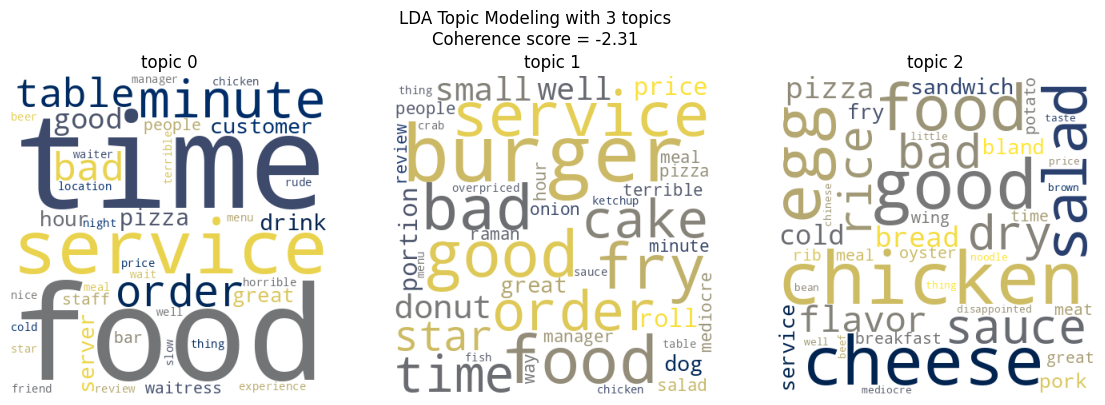

In [37]:
# use custom function wordCloudAndCoherence to display 1 wordcloud for each topic and compute coherence_score
mf.wordCloudAndCoherence(model=model, corpus=tfidf_vector)

Les topics ne sont pas facilement interprétables :
- le **score de cohérence est moyen**, même s'il n'existe pas vraiment de valeur cible (voir plus bas)
- le **nombre de topics** n'est peut-être pas pertinent
- comme préssenti, les **noms de plats/consommations** prennent **l'ascendant sur les autres mots** : On a l'exemple avec *pizza*, *burger* ou encore *chicken* : il n'y a **pas vraiment de raison qu'un des sujets de mécontement principaux soit le plat *pizza* en tant que tel**. En revanche il est probable que des commentaires portant sur des sujets différents (comme la qualité de la nourriture d'un côté et la gentillesse du personnel de l'autre) comportent chacun le mot *pizza*... Nous allons tenter de mettre à jour notre liste `customStopWords` en conséquence.
- des **mots rares ont peut-être pris trop d'importance**. Nous allons par la suite essayer d'appliquer un filtre dans notre fonction `makeDictionaryAndFilter`

Malheureusement cette méthode présente des inconvénients :
- le `wordcloud` :
    - ne nous permet **pas vraiment de comprendre le degré de différence entre les topics**
    - apporte du **biais aléatoire dans l'interprétation de l'importance des mots** (orientation, position, couleur)
    - ne nous permet pas de visualiser l'**importance relative des topics**
- le score de `coherence` :
    - est global
    - n'apporte **pas d'information individuelles sur les topics**
    - n'a pas vraiment de valeur cible... Il s'agit d'**un score plus utile pour comparer, à optimiser**
    - ne **garantit pas** à lui-seul l'obtention de **topics interprétables**

### NLP - 4.1.3) Représentation de nos topics grâce à `pyLDAvis`

`pyLDAvis` est une librairie spécialisée permettant de :
-  avoir une vue d'ensemble d'un modèle de topic modeling
-  explorer en détail chaque topic
-  explorer en détail chaque mot par rapport aux topics

Il est composé de plusieurs parties :
- ***Intertopic Distance Map*** :
    - représentation 2D **des topics dans l'espace des probabilités de mots dans les topics (matrice topics/mots issue du modèle de LDA)**. Cette **réduction** de dimension 2D est issue d'un **MDS** (multidimensional scaling)
    - la représentation de chaque topic dans cet espace réduit **permet ainsi d'apprécier les distances qui les séparent les uns des autres** dans l'espace plus large, et donc **s'ils sont bien différents**
    - la taille de chaque topic est elle liée à l'**espace des probabilités des topics dans les documents (matrice documents/topics issue du modèle LDA)**. La **somme des probabilités** sur tous les documents de chaque topic permet de définir sa taille. Elle représente donc la **prédominance du topic dans le corpus**
- liste des mots les plus importants :
    - **sans spécifier** un topic : ***Top-30 Most Salient Terms*** :
        - mots classés selon la *saliency* : liée à la fréquence globale de chaque mot dans le corpus.
        - **barres bleus** : fréquences **à l'échelle du corpus**
    - **en sélectionnant** un topic : ***Top-30 Most Relevant Terms for Topic n*** :
        - mots classés selon la *relevance* : liée à la probabilité de chaque mot dans un topic particulier. Ce classement évolue en fonction du paramètre λ :
            - **λ tend vers 1** : la *relevance* met plus en avant **les mots les plus présents au sein du topic**
            - **λ tend vers 0** : la *relevance* normalise cette probabilité du mot pour ce topic avec la probabilité du mot au global dans le corpus. On voit alors apparaître **non pas les mots forcément les plus présents, mais les mots les plus distinctifs du topic analysé**
        - **barres rouges** : fréquences estimées **au sein du topic**
    - il est **aussi possible de sélectionner un mot** en particulier : les **tailles** des topics de l'**Intertopic Distance Map** représentent alors **seulement la répartion de ce mot choisi aux sein des topics**.

In [38]:
# use "prepare" function to create the pyLDAvis
vis_data  = gensimvis.prepare(
    topic_model=model,
    corpus=tfidf_vector,
    dictionary=dictionary
)
# display
pyLDAvis.display(vis_data)

Ce que l'on peut en retenir :
- nos topics ne sont pas de tailles équivalentes, ce qui en soit n'est pas un problème
- le sens des topics n'est vraiment pas facilement interprétable... **Les mots caractéristiques de chaque topic ne nous informent pas vraiment sur l'objet du mécontentement...**

## NLP - 4.2) LDA - Améliorer notre pré-traitement

Voyons si nous pouvons améliorer notre modèle. Commençons par modifier notre pré-traitement :

Nous allons :
- **augmenter un peu le nombre de commentaires** pour donner **plus de données** au modèles
- rajouter plus de "mots-vides" personnalisés, en **rajoutant des noms de plat, de consommation, etc.** notamment
- **utiliser la fonctionnalité de filtre** sur les mots rares et les mots fréquents

In [39]:
# create a pipeline with all our preprocessing steps

# size of sample
revSize = 60000
# store the path of the business json file
busPath="dataYelp/yelp_academic_dataset_business.json"
# store custom stopwords
customStopWords = [
    # "time",
    "restaurant",
    "menu",
    "diner",
    "dinner",
    "bistro",
    "casino",
    "buffet",
    # "cafe",
    "dining",
    "hotel",
    # "meal",
    "lunch",
    # "eat",
    "place",
    "bar",
    "drink",
    "review",
    "star",
    "beer",
]+[
    "food",
    "crab",
    "burger",
    "pizza",
    "chicken",
    "sandwich",
    "cheese",
    "rice",
    "salad",
    "shrimp",
    "sauce",
    "meat",
    "bread",
    "bean",
    "wing",
    "taco",
    "pork",
    "chip",
    "bacon",
    "toast",
    "egg",
    "sushi",
    "steak",
    "roll",
    "wine",
    "water",
    "fish",
    "oyster",
    "fry",
    "rib",
    "gumbo",
    "coffee",
    "vietnamese",
    "soup",
    "potato",
    "onion",
    "mexican",
    "burrito",
    "taco",
    "noodle",
    "beef",
    "cake",
    "pasta",
    "beef",
    "bagel",
    "tea",
    "lettuce",
    "indian",
    "chineese",
    "asian",
    "bbq",
    "waffle",
    "pancake",
    "biscuit",
    "breakfast",
    "donut",
    "greek",
    "mushroom",
    "cheesesteak",
    "cream",
    "thai",
    "pretzel",
    "croissant",
    "donut",
    "mussel",
    "lobster",
    "pepperoni",
    "eggplant",
    "mozzarella",
    "pepper",
    "garlic",
    "hamburger",
    "seafood",
    "crouton",
    "milkshake",
    "vodka",
    "sake",
    "bourbon",
    "margarita",
    "chinese",
    "smoothie",
    "pineapple",
    "soy",
    "olive",
    "applebee",
    "pita",
    "hummus",
    "korean",
    "cuban",
    "duck",
    "apple",
    "fajita",
    "breadstick",
    "cookie",
    "tofu",
    "curry",
    "tuna",
    "calamari"
    
]

# create steps
reviewsSteps = [
    ("reviewsLoader", mf.reviewsLoader(busPath=busPath, revSize=revSize, revStars=[1,2], random_state=16)), # loader for .json file
    ("lowerCasor", mf.lowerCasor()), # lowercase converter
    ("urlRemover", mf.urlRemover()), # URL remover
    ("escapeSequencesRemover", mf.escapeSequencesRemover()), # escape sequences remover
    ("repeatedCharsCorrector", mf.repeatedCharsCorrector()), # repeated characters corrector
    ("textCleaner", mf.textCleaner(customStopWords=customStopWords, posToKeep=["NOUN","ADJ"])), # text cleaner
    ("dictAndVectorMaker", mf.dictAndVectorMaker(no_below=10, no_above=0.9, smartirs = 'nfc', applyTfidf = True)), # dict (with filters) and tfidf maker
    
]

La taille de notre échantillons étant plus importante, nous allons enregistrer ces résultats :

In [40]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/nlpDictAndVector"):
    os.mkdir("mySaves/nlpDictAndVector")

In [41]:
%%time
# if no files in directory, create our pipeline and use it to obtain "tfidf_vector" and "dictionary"
if "tfidf_vector.joblib" not in os.listdir("mySaves/nlpDictAndVector") :
    # create scikit learn pipeline
    generalReviewsPipe = Pipeline(steps=reviewsSteps, verbose=True)

    # fit_transform
    tfidf_vector, dictionary = generalReviewsPipe.fit_transform("dataYelp/yelp_academic_dataset_review.json")

    # save
    dump(tfidf_vector, "mySaves/nlpDictAndVector/tfidf_vector.joblib")
    dump(dictionary, "mySaves/nlpDictAndVector/dictionary.joblib")
    
    del generalReviewsPipe, reviewsSteps
    gc.collect()

else :
    # load existing .joblib
    tfidf_vector = load("mySaves/nlpDictAndVector/tfidf_vector.joblib")
    dictionary = load("mySaves/nlpDictAndVector/dictionary.joblib")

    del reviewsSteps
    gc.collect()

CPU times: total: 7.67 s
Wall time: 14.4 s


Nous avons maintenant notre représentation TF-IDF et notre dictionnaire mis à jour avec les nouveaux paramètres. 

Pour la suite, au lieu de créer directement notre LDA, nous allons tester différents paramètres `num_topics` :

## NLP - 4.3) LDA - Le score de cohérence pour déterminer le bon nombre de sujets ?

Nous allons essayer d'optimiser le nombre de topics grâce au score de cohérence :

In [42]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/coherencesPlot"):
    os.mkdir("mySaves/coherencesPlot")

CPU times: total: 31.2 ms
Wall time: 63.3 ms


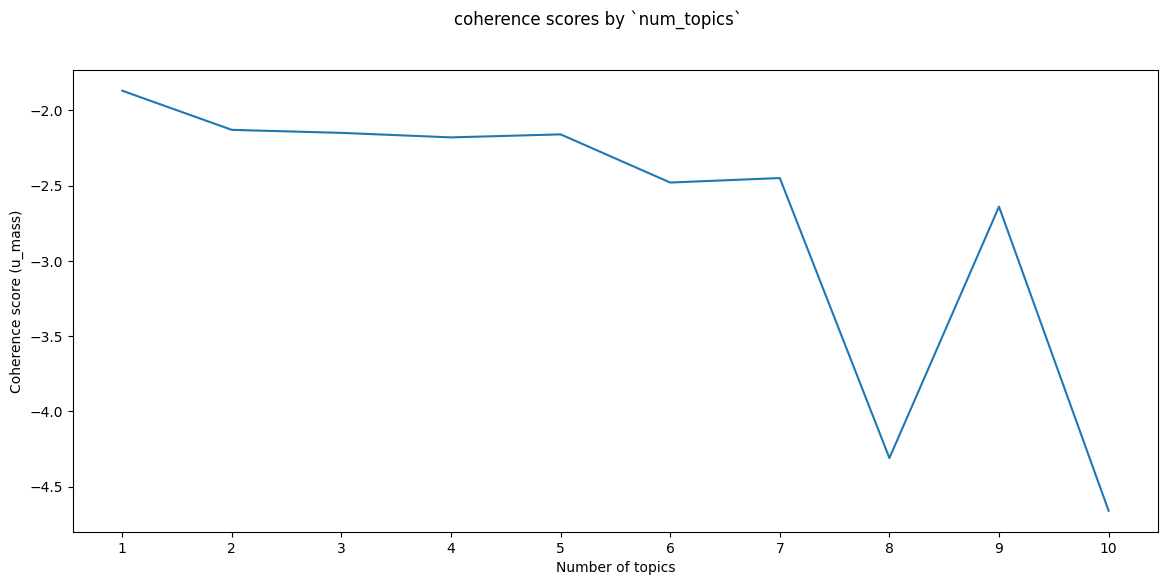

In [43]:
%%time
# if no files in directory, use custom function plotDifferentNtopics to compute coherence_score for different values of "num_topics"
if "coherencesPlot.joblib" not in os.listdir("mySaves/coherencesPlot") :
    coherencesPlot = mf.plotDifferentNtopics(nTopicsList=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dictionary=dictionary, corpus=tfidf_vector)

    # save
    dump(coherencesPlot, "mySaves/coherencesPlot/coherencesPlot.joblib")


else :
    # load existing .joblib
    load("mySaves/coherencesPlot/coherencesPlot.joblib")

Il n'y a pas vraiment de pic ... Nous observons néanmoins une chute de cohérence après 5 topics. Nous allons regarder ce que cela donne pour 3, 4 et 5 topics :

## NLP - 4.4) LDA - 3 topics

Toujours avec 3 topics :

In [44]:
# create the LDA model 
model = LdaModel(
    corpus=tfidf_vector,
    num_topics=3,
    id2word=dictionary,
    random_state=16
)

Regardons ce que cela donne avec `PyLDAvis` :

In [45]:
# use the "prepare" function 
vis_data  = gensimvis.prepare(
    topic_model=model,
    corpus=tfidf_vector,
    dictionary=dictionary
)
# display
pyLDAvis.display(vis_data)

Par rapport à notre premier essai :
- les sujets sont toujours bien séparés au niveau de l'espace des mots,
- les tailles sont un peu moins hétérogènes,
- au niveau du sens : 
    - le **comportement du personnel et le temps d'attente**, avec des mots comme *table, server, minute, hour, rude, manager, experience, incorrect, customer, hostess, staff*, etc.
    - le **rapport qualité / prix**, avec des mots comme *flavor, bland, dry, taste, price, portion, small*, etc.
    - la **livraison**, avec des mots comme *delivery, order, hour, service, slow, min, minute, driver, phone, refund*, etc.

## NLP - 4.4) LDA - 4 topics

Maintenant avec 4 topics :

In [46]:
# create the LDA model 
model = LdaModel(
    corpus=tfidf_vector,
    num_topics=4,
    id2word=dictionary,
    random_state=16
)

Regardons ce que cela donne avec `PyLDAvis` :

In [47]:
# use the "prepare" function 
vis_data  = gensimvis.prepare(
    topic_model=model,
    corpus=tfidf_vector,
    dictionary=dictionary
)
# display
pyLDAvis.display(vis_data)

les sujets se distinguent un peu plus :
- le **comportement du personnel et le temps d'attente**, avec des mots comme *minute, reservation, order, manager, rude, hour, employee, server, waitress, hostess, service, time, busy, attitude*, etc.
- la **qualité du plat et son prix**, avec des mots comme *flavor, dry, bland, salty, quality, taste, poisonning, soggy, price, portion, small*, etc.
- l'**hygiène**, avec des mots comme *dirty, flour, filthy, clean, hair, glove, mask, fly, bathroom, cleanliness, cockroach, rat, restroom, toilet, disgusting, bug*, etc.
- la **livraison**, avec des mots comme *driver, delivery, uber, masked, order, drive, time, hour, slow, cold*,etc. 

## NLP - 4.4) LDA - 5 topics

Maintenant avec 5 topics :

In [48]:
# create the LDA model 
model = LdaModel(
    corpus=tfidf_vector,
    num_topics=5,
    id2word=dictionary,
    random_state=16
)

Regardons ce que cela donne avec `PyLDAvis` :

In [49]:
# use the "prepare" function 
vis_data  = gensimvis.prepare(
    topic_model=model,
    corpus=tfidf_vector,
    dictionary=dictionary
)
# display
pyLDAvis.display(vis_data)

Certains sujets sont plus proches les uns des autres, à voir ce que cela donne au niveau du sens. On a :
- l'**ambiance** avec des mots comme *table, reservation, music, loud, party, birthday, noisy, dance*, etc.
- l'**attitude du personnel et le temps d'attente**, avec des mots comme *table, delivery, understaffed, reservation, minute, order, manager, rude, hour, employee, waitress, service, time, busy, attitude*, etc.
- **2 sujets très proches sur la nourriture**, avec des mots en commun comme *flavor, soggy, dry, taste*, etc. :
    -  l'un un peu plus axé sur la **qualité du plat et son prix**, avec des mots comme *portion, price, small, quality, taste*, etc.
    -  l'autre se concentrant plus exclusivement sur la nourriture
- l'**hygiène**, avec des mots comme *dirty, filthy, bathroom, glove, floor, mask, health, restroom, toilet, disgusting, rat, cleaning, roach, hair*, etc.

## NLP - 4.5) Conclusion

Il est **difficile de conclure sur le nombre idéal de topics** :
- se contenter de 3 met de côté l'hygiène
- conserver 4 topics est intéressant car les sujets sont clairs, avec l'hygiène qui se rajoute,
- enfin avec 5 topics nous avons réussi à obtenir un sujet différent avec l'ambiance, mais la livraison disparaît et le rapport qualité/prix se divise en 2 sous-thèmes pas très clairs...

Nous pouvons néanmoins **conclure sur le faisabilité du projet** :
- le fait d'**ajouter plus de commentaires et d'affiner la préparation des données** a permis de **trouver de vrais sujets de mécontentement**,
- il est donc tout à fait possible :
    - que l'utilisation de **toute la base de données** nous permette de faire disparaître les limitations que nous avons observé
    - qu'une **recherche plus poussée des meilleures paramètres** de notre pipeline (`gridsearchCV`, `BayesSearchCV`, etc.) permette d'améliorer le modèle:
        - filtrage,
        - liste de stopwords,
        - le nombre de topics,
        - les autres hyper-paramètres du modèle (`alpha` et `eta` notamment, qui conditionne le côté plus ou moins *lisse* des distributions de chaque document en topics et de chaque topic en mots)
- **cependant** il faut noter que :
    - nous avons dû ajouter **"à la main"** beaucoup de *stopwords* spécifiques... A voir si ce procédé peut d'une quelconque manière être évité...
    - après quelques essais il s'avère que les **thèmes détectés par le modèle sont instables** (notamment en fonction de la liste des *stopwords* spécifiques)

Il serait intéressant, dans le cadre de la poursuite du projet, de tester d'autres modèles (`LSA`? `BERTopic`? autre ?).

# PARTIE II.A - ANALYSER LES PHOTOS POUR DÉTERMINER LES CATÉGORIES DES PHOTOS - SIFT

Dans cette partie nous allons utiliser les photos du jeu de données de Yelp pour nous assurer de la faisabilité de labelliser automatiquement les photos postées sur la plateforme.

# CV-SIFT - 0) Méthode

Nous avons la chance que les photos Yelp soient **déjà labellisées** : L'objectif **final** est d'entraîner un algorithme de **classification supervisée** sur celles-ci afin d'utiliser le modèle ultérieurement **sur les photos qui seront publiées sur Avis Restau**.

Le but ici n'est pas de réaliser ce projet entièrement. L'objectif **préliminaire** est d'**analyser** les photos pour vérifier la faisabilité : 
- Nous réaliserons donc toutes les étapes préalables à l'entraînement d'un algorithme de classification :
    - réaliser le **pré-traitement** sur N images
    - **extraire les features** (nous utiliserons le **SIFT**) pour obtenir les descripteurs de nos N images
    - création des bag-of-visual-words :
        - **trouver les "visual words" grâce à un algorithme KMeans** appliqué sur l'ensemble des descripteurs trouvés
        - construire l'**histogramme de chaque image** en fonction de ce dictionnaire de "visual-words"
        - contruire ainsi notre **matrice des "bag-of-visual-words"**, de taille N image x taille dictionnaire
    - adapter la **pondération** des visual-words grâce à un **TF-IDF**<br>
    
    **... mais au lieu de réaliser ce travail sur un très grand nombre de photos (avec un split préalable en train/test set, etc.), nous ne prendrons que quelques photos de chaque catégorie.**<br>

- Nous testerons alors la **faisabilité sur ce petit échantillon** avec un **clustering KMeans** avec **K = le nombre de labels** pour vérifier que nos features peuvent bien regrouper nos labels :
    - réduction de **dimension préalable** via une ACP
    - appliquer le KMeans
    - effectuer une mesure de **similarité ARI**
    - analyser les catégories les mieux regroupées (via une **matrice de confusion** entre les catégories et les clusters prédits)<br><br>


- Nous tâcherons également de visualiser nos N images dans cet espace des features pour **analyser si les catégories/labels fournies ressortent** :
    - utilisation du même espace réduit par l'ACP
    - réduction de dimension par **T-SNE**, idéal pour représenter des données en grande dimension
    - visualisation :
        - des catégories
        - des clusters

# CV-SIFT - 1) Imports

In [50]:
# opencv, computer vision tools, used for SIFT and its preprocessing
import cv2

# KMeans clustering algorithm
from sklearn.cluster import KMeans
# scikit learn metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import f1_score, classification_report, precision_score

# pipeline
from sklearn.pipeline import Pipeline 

# VGG16 from keras, used for transfer learning and its preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# data manipulation
import pandas as pd  # to manipulate the dataset with dataframes
import numpy as np  # for statistics and calculations

# data viz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# image annotations
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import ListedColormap, to_rgb

# TSNE embedding
from openTSNE.sklearn import TSNE as openTSNE  # openTSNE (quicker)

# custom functions
import myFunctions as mf
%load_ext autoreload

%autoreload 2

# for memory management
import gc  

# file and directory management
import os
# to make saves
from joblib import dump, load  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CV-SIFT - 2) Sélection de 150 photos par catégorie

Le dataset des photos Yelps contient :
- un dossier contenant les photos au format jpg
- un json contenant différentes informations :
    - "photo_id" - le nom du .jpg
    - "business_id" - l'identifiant de l'établissement concerné
    - "caption" - la légende de la photo
    - "label" - la catégorie, parmi :
        - "food",
        - "drink",
        - "menu",
        - "inside",
        - "outside"


## CV-SIFT - 2.1) Nos photos

Commençons par charger notre dataset contenant les données sur nos photos.
Nous rajoutons également une colonne avec le chemin d'accès de chaque photo.

In [51]:
photoData = mf.loadYelpJsonPhotosData(
    jsonPath="dataYelp/photos.json", 
    photosDirPath="dataYelp/photos/"
)

In [52]:
photoData

photo_id             business_id  \
0       zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1       HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2       vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3       pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4       H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                        ...                     ...   
200095  4Zia9NkAfQNjMfcIDhwJ-g  2HxkdqHmbYGj_BH1bLaiSw   
200096  KB96KRZRhRm8hUkI-OpGEA  _gVyuTRb_6HM-SNtqbpevQ   
200097  Klmojvaf2_2dP1XKzTsFmQ  NUyEOjfAl3HvkpzSpdwqeA   
200098  FNEiq7Mogec7t31OaU5juw  hE6YsHHV0fCz_UrGS4o6VA   
200099  NHEtLh7APk7Yssjo0h45VA  VIYvcX9SScnqmoI0so1KZA   

                                                  caption    label  \
0       Nice rock artwork everywhere and craploads of ...   inside   
1                                                          outside   
2                                          oyster shooter    drink   
3                                           Shrimp scampi     food   
4                                                             food   
...                                                   ...      ...   
200095                                            #Nektar     food   
200096                                                      inside   
200097                                                        food   
200098                               Drinks by the water!    drink   
200099                                                        food   

                                        photo_path  
0       dataYelp/photos/zsvj7vloL4L5jhYyPIuVwg.jpg  
1       dataYelp/photos/HCUdRJHHm_e0OCTlZetGLg.jpg  
2       dataYelp/photos/vkr8T0scuJmGVvN2HJelEA.jpg  
3       dataYelp/photos/pve7D6NUrafHW3EAORubyw.jpg  
4       dataYelp/photos/H52Er-uBg6rNrHcReWTD2w.jpg  
...                                            ...  
200095  dataYelp/photos/4Zia9NkAfQNjMfcIDhwJ-g.jpg  
200096  dataYelp/photos/KB96KRZRhRm8hUkI-OpGEA.jpg  
200097  dataYelp/photos/Klmojvaf2_2dP1XKzTsFmQ.jpg  
200098  dataYelp/photos/FNEiq7Mogec7t31OaU5juw.jpg  
200099  dataYelp/photos/NHEtLh7APk7Yssjo0h45VA.jpg  

[200100 rows x 5 columns]

Regardons nos catégories :

In [53]:
# compute the count of each image category
photoData.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## CV-SIFT - 2.2) Faire un échantillons

Prenons un échantillons de 150 lignes par label :

APARTÉ : nous avons commencé par en sélectionner 1500 par catégorie. Cette pré-sélection n'a pas d'intérêt pour le projet et nous a juste permis de libérer de l'espace disque en supprimant la grande majorité des photos.

In [54]:
%%time
# use custom function sampPhotos to first sample 1500 photos by category
photoData1000 = mf.sampPhotos(
    photoDf=photoData, 
    nToKeepByClass=1000, 
    photosDirPath="dataYelp/photos/",
    random_state=16
)

# then, erase (only if deleteMostPhotos has been set to True at the beginning of the Notebook) all the remaining photos from disk
mf.deletePhotos(
    photoDfSamp=photoData1000,
    photosDirPath="dataYelp/photos/",
    deleteMostPhotos=deleteMostPhotos
)

# use sampPhotos to choose our 150 photos by category
photoData150 = mf.sampPhotos(
    photoDf=photoData1000, 
    nToKeepByClass=150, 
    photosDirPath="dataYelp/photos/",
    random_state=16
)

photoData150

No photo deleted
CPU times: total: 1.34 s
Wall time: 2.15 s


photo_id             business_id  \
192384  2-Ik-fVsEEnnS8QSJQRVZw  xWfm4AwLZr-B97fYVsIgCA   
75873   2rbdATwKOuUXFIj7qqJRNA  K6-YNiZ9ljyEc5fxwkMmyA   
8238    pTXSzybFlPFsdFReZ9MXXQ  TLpuvhkMKx8MGTE7W3Z-Lw   
193135  ZbwPzMwcwvSW0A6Ou984Kw  bf5oyM3oQk-Av3Jaqg2yog   
159621  ygS4TqORslFe6vYKqJQ_IA  fZ92MJ1hbEMXqwWTSwF9lA   
...                        ...                     ...   
74253   mBWcQwuzsA63DsCPSWE5KA  PcbSDN3civo7-7uAsHFqXA   
80558   evhVnmpiN6HCImXQn-4H4Q  QUyLaPjsoZiRJ-RUBVa5rA   
53631   Ir6QF-TH-QhZLOlWNPW0mg  FBSsH6njOt84UYUMN-J32w   
142718  utSEvT3v5vPJ_mzCFohqgQ  Un-UDVOuv1co3TMmGaumxA   
61972   Np-hYU9NTm0OtS9R0RnB4w  VNvJuCTMdGBj4lwC0L1Ghg   

                                                  caption    label  \
192384                                                       drink   
75873                                                        drink   
8238                                     Kentucky Sangria    drink   
193135                                          Long John    drink   
159621                                                       drink   
...                                                   ...      ...   
74253   Come join us Sept 15th from 11 am to 3 am for ...  outside   
80558                                               Mural  outside   
53631                                          Mazaj Cafe  outside   
142718  Had an amazing view with a scrumptious lunch. ...  outside   
61972                       First time here and loved it!  outside   

                                        photo_path  
192384  dataYelp/photos/2-Ik-fVsEEnnS8QSJQRVZw.jpg  
75873   dataYelp/photos/2rbdATwKOuUXFIj7qqJRNA.jpg  
8238    dataYelp/photos/pTXSzybFlPFsdFReZ9MXXQ.jpg  
193135  dataYelp/photos/ZbwPzMwcwvSW0A6Ou984Kw.jpg  
159621  dataYelp/photos/ygS4TqORslFe6vYKqJQ_IA.jpg  
...                                            ...  
74253   dataYelp/photos/mBWcQwuzsA63DsCPSWE5KA.jpg  
80558   dataYelp/photos/evhVnmpiN6HCImXQn-4H4Q.jpg  
53631   dataYelp/photos/Ir6QF-TH-QhZLOlWNPW0mg.jpg  
142718  dataYelp/photos/utSEvT3v5vPJ_mzCFohqgQ.jpg  
61972   dataYelp/photos/Np-hYU9NTm0OtS9R0RnB4w.jpg  

[750 rows x 5 columns]

Nous pouvons maintenant commencer le travail.

In [55]:
%%time
# use custom fonction loadImages
photos = mf.loadImages(photoData150["photo_path"].to_list())

CPU times: total: 3.08 s
Wall time: 5.45 s


## CV-SIFT - 2.3) Quelques exemples

Regardons à quoi ressemble nos images :

In [56]:
# display 2 images per category

# initiate a dictionnary to store images and their position in the list of photos
examplesPhotoDict = {
    "idx" : {},
    "raw" : {}
}

# get indexes of the first 2 images of each category
# iterate on categories
for i,cat in enumerate(photoData150["label"].unique()) :
    # reset photoData150 index
    photoData150_reset = photoData150.reset_index(drop=True)
    # filter on this category and keep the 2 first images
    mask = photoData150_reset["label"] == cat
    imIdx = photoData150_reset.loc[mask][:2].index
    # put index in dictionary
    examplesPhotoDict["idx"][cat] = imIdx

# put corresponding images in dictionary
examplesPhotoDict["raw"] = {
    cat : [photos[i] for i in imIdx] 
    for cat,imIdx in examplesPhotoDict["idx"].items()
}

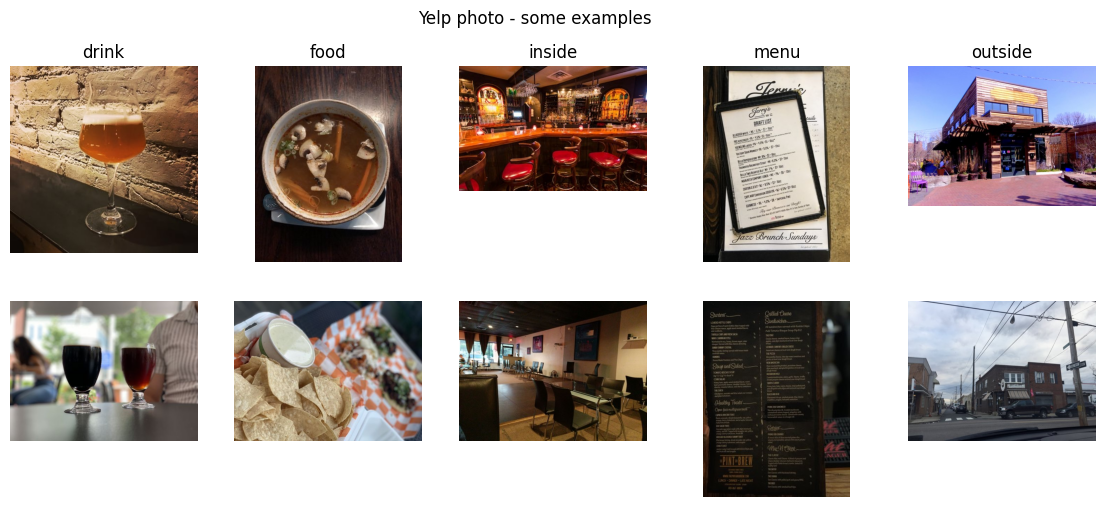

In [57]:
# use custom function displayImagesFromDict to show images stored in the dictionary
mf.displayImagesFromDict(examplesPhotoDict["raw"],title="Yelp photo - some examples")

# CV-SIFT - 3) Pré-traitement

## CV-SIFT - 3.1) Conversion en nuance de gris

In [58]:
%%time
# use custom function to convert photos to gray scale
grayPhotos = mf.myConvertGrayScale(photos, inputFormat="RGB")

CPU times: total: 719 ms
Wall time: 125 ms


In [59]:
# update our photos example, adding gray photos
examplesPhotoDict["gray"] = {
    cat : [grayPhotos[i] for i in imIdx] 
    for cat,imIdx in examplesPhotoDict["idx"].items()
}

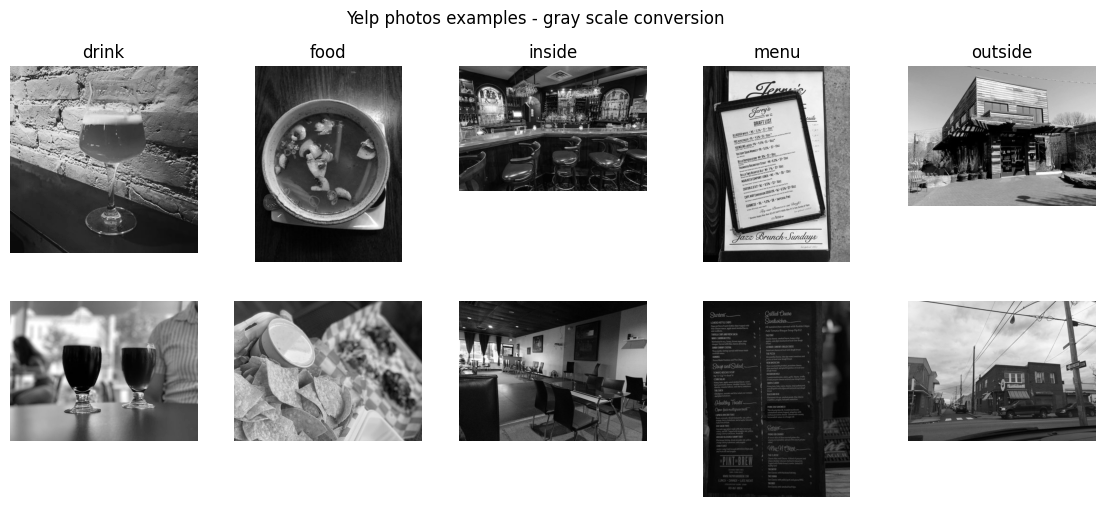

In [60]:
# use custom function displayImagesFromDict to show images stored in the dictionary
mf.displayImagesFromDict(examplesPhotoDict["gray"],title="Yelp photos examples - gray scale conversion")

## CV-SIFT - 3.2) Égalisation de l'histogramme

In [61]:
%%time
# use custom function to equalize our photos' histograms
equalPhotos = mf.myEqualizeHist(grayPhotos)

CPU times: total: 172 ms
Wall time: 235 ms


In [62]:
# update our photos examples, adding equalized photos
examplesPhotoDict["equal"] = {
    cat : [equalPhotos[i] for i in imIdx] 
    for cat,imIdx in examplesPhotoDict["idx"].items()
}

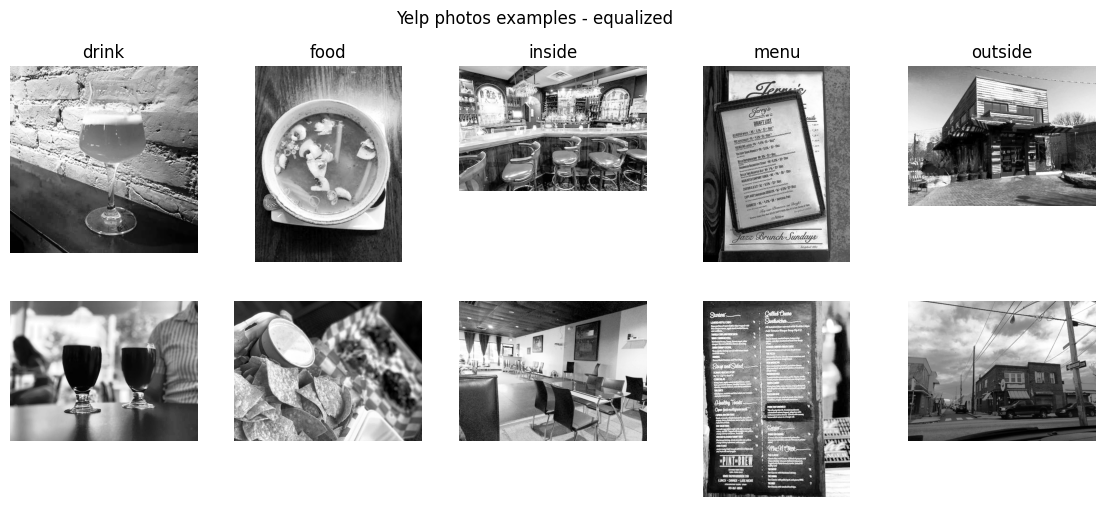

In [63]:
# use custom function displayImagesFromDict to show images stored in the dictionary
mf.displayImagesFromDict(examplesPhotoDict["equal"],title="Yelp photos examples - equalized")

## CV-SIFT - 3.3) Filtrage du bruit

In [64]:
%%time
# use custom function to remove noise and smooth our photos
gaussianPhotos = mf.myGaussianBlur(equalPhotos, ksize=(3,3))

CPU times: total: 500 ms
Wall time: 95.2 ms


In [65]:
# update our photos examples, adding equalized photos
examplesPhotoDict["gaussian"] = {
    cat : [gaussianPhotos[i] for i in imIdx] 
    for cat,imIdx in examplesPhotoDict["idx"].items()
}

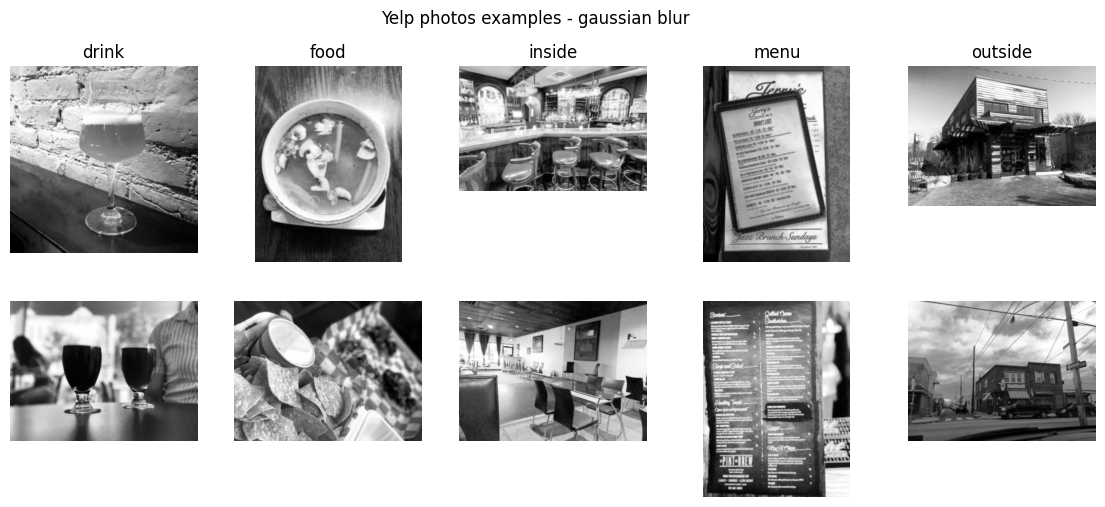

In [66]:
# use custom function displayImagesFromDict to show images stored in the dictionary
mf.displayImagesFromDict(examplesPhotoDict["gaussian"],title="Yelp photos examples - gaussian blur")

## CV-SIFT - 3.4) Extraction de features

In [67]:
%%time
# use custom function to remove noise and smooth our photos
keyPointsPhotos, descriptorsList = mf.mySIFT(gaussianPhotos)

CPU times: total: 2min 21s
Wall time: 50.1 s


In [68]:
# update our photos examples, adding photos with keypoints drawn
examplesPhotoDict["keypoints"] = {
    cat : [keyPointsPhotos[i] for i in imIdx] 
    for cat,imIdx in examplesPhotoDict["idx"].items()
}

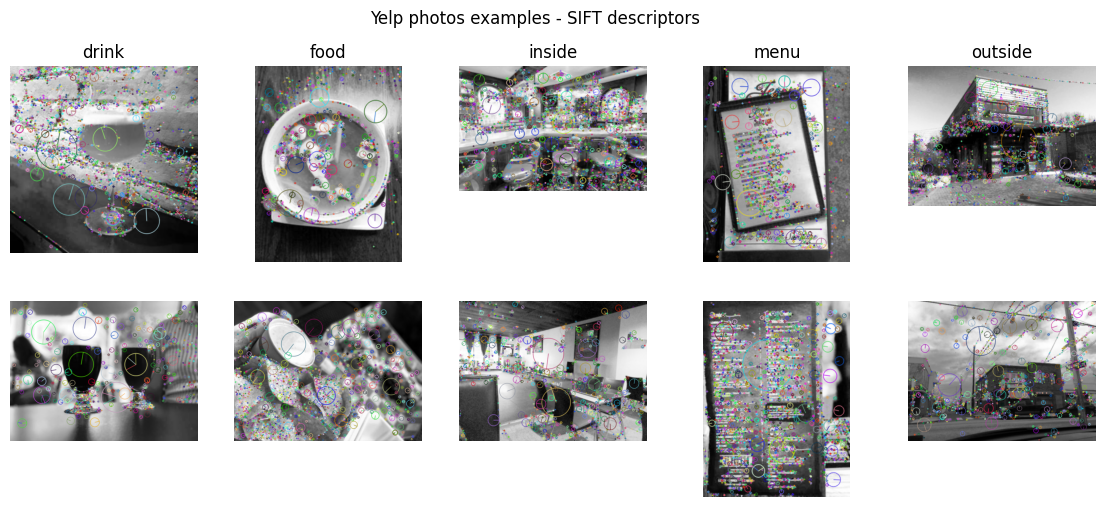

In [69]:
# use custom function displayImagesFromDict to show images stored in the dictionary
mf.displayImagesFromDict(examplesPhotoDict["keypoints"],title="Yelp photos examples - SIFT descriptors")

Aparté - exporter le dictionnaire des exemples de photos :

In [70]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/examplesPhotoDict"):
    os.mkdir("mySaves/examplesPhotoDict")

In [71]:
%%time
# if no files in directory, save
if "examplesPhotoDict.joblib" not in os.listdir("mySaves/examplesPhotoDict") :
    # save
    dump(examplesPhotoDict, "mySaves/examplesPhotoDict/examplesPhotoDict.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


## CV-SIFT - 3.5) Bag of Visual Words

Nous avons maintenant une liste de descripteurs SIFT par image. L'idée est maintenant de considérer :
- chaque image comme le document d'un corpus
- les descripteurs de chaque image comme les mots de ce document
Mais tous les descripteurs étant uniques, il n'y aurait pas trop de sens à considérer à les considérer chacun comme un mot.
L'astuce consiste à considérer les descripteurs similaires comme un même mot, un *visual word* : 

### CV-SIFT - 3.5.1) Extraire le dictionnaire grâce à un algorithme de clustering KMeans

Création d'un **dictionnaire de visual words** :
- **rassemblement de tous les descripteurs** des images
- utilisation d'un algorithme de **clustering** (`MiniBatchKMeans`) : **chaque centroïde de cluster correspond à un *visual word***

In [72]:
%%time
# use custom function makeDictionnary to create and fit a MiniBatchKmeans whose clusters centroids will be our visual words
# (the number of clusters used is by default the square root of the total number of descriptors)
visualDictKmeans = mf.makeDictionnary(descriptorsList=descriptorsList)

CPU times: total: 1min 55s
Wall time: 4min 18s


### CV-SIFT - 3.5.2) Contruire le BOVW

Création **matrice des Bag-of-Visual-Words** :
- **pour chaque descripteur** de **chaque image**, appliquer le modèle de clustering (dictionnaire) pour **attibuer le visual word correspondant**
- pour **chaque image**, compter le **nombre d'occurences de chaque *visual word*** présent
- intégrer **ces histogrammes à une matrice** (nombre d'images X nombre de *visual words*)

In [73]:
# use our fitted visualDictKmeans to associate each descriptor to a visual word 
# and count appearance of each descriptor in each image to create our BOVW dataframe
# using custom function makeBOVW
BOVW_df = mf.makeBOVW(visualDictKmeans, descriptorsList)

In [74]:
BOVW_df

0     1     2     3     4     5     6     7     8     9     ...  1070  \
0       5     1     1     1     2     0     2     0     0     0  ...     0   
1       0     0     0     0     1     2     1     1     0     0  ...     1   
2       0     0     0     0     0     2     1     0     0     1  ...     0   
3       0     1     0     0     1     1     3     0    13     2  ...     1   
4       0     0     0     0     0     0     1     0     2     1  ...     0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
745     2     0     0     0     1     0     2     0     1     3  ...     2   
746     1     0     2     0     1     0     0     2     1     0  ...     3   
747     0     0     0     0     0     0     0     0     4     0  ...     2   
748     1     0     0     0     0     4     6     3     3     2  ...     2   
749     2     4     0     0     1     1     4     3    12     2  ...     2   

     1071  1072  1073  1074  1075  1076  1077  1078  1079  
0       1     0     1     2     1     0     0     7     2  
1       1     0     0     0     2     1     0     0     1  
2       0     1     0     0     0     0     1     1     0  
3       2     0     0     0     2     0     1     1     0  
4       0     3     0     0     0     0     0     0     0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
745     1     1     0     3     1     3     0     1     0  
746     1     3     0     2     0     0     0     1     1  
747     0     0     1     2     2     0     1     0     0  
748     2     1     2     1     1     1     2     1     4  
749     2     4     1     0     5     5     4     1     2  

[750 rows x 1080 columns]

A noter qu'il est possible d'obtenir le même résultat avec `gensim` :

In [75]:
# create a gensim list of bag-of-visual-words dense vectors 

# create corpus of documents (list of visual-words)
# for each image, predict the cluster (i.e. the visual word) of each of its descriptors
# thus, for each image, we got an array of visual word, an "image-document"
visualWordsCorpus = [visualDictKmeans.predict(descriptors) for descriptors in descriptorsList]
# for gensim compatibility, cast visual words to strings
visualWordsCorpus = [np.array([str(visualWord) for visualWord in doc]) for doc in visualWordsCorpus]
# display an example (the one with the fewest words)
exampleId = np.argmin(np.array([len(visualWords) for visualWords in visualWordsCorpus]))
print("For example, image "+str(exampleId)+" list of visual-words, i.e. its 'document' representation, is :\n",visualWordsCorpus[exampleId])

# use gensim Dictionary function to (re-)create the dictionary 
# (we need the gensim dictionary object to compute our bag of (visual)words)

# import corpora module
from gensim import corpora
# create dictionary from corpus
visualWordsDictionary= corpora.Dictionary(visualWordsCorpus)

# create the list of bag-of-visual-words vectors
bow_visualWordsCorpus = [visualWordsDictionary.doc2bow(imageDoc) for imageDoc in visualWordsCorpus]
# display the same example
print("Image "+str(exampleId)+" gensim's bag-of-visual-words vector is :",bow_visualWordsCorpus[exampleId])

For example, image 235 list of visual-words, i.e. its 'document' representation, is :
 ['690' '192' '1059' '1059' '675' '1033' '192' '91' '1059' '147' '374'
 '744' '637' '821' '721' '555' '484' '667' '834' '874' '507' '167' '879'
 '330' '821' '332' '352' '482' '675' '537' '97' '351' '580' '233' '765'
 '474' '830' '580' '567' '1073' '675' '597' '552' '201' '23' '910' '1024'
 '743' '894' '514' '35' '216' '940' '86' '980' '103' '678' '23' '1003'
 '977' '475' '913' '1076' '587' '114' '305' '1004' '722' '213' '28' '1033'
 '979' '276' '921' '945']
Image 235 gensim's bag-of-visual-words vector is : [(6, 1), (7, 1), (27, 1), (30, 2), (48, 3), (59, 1), (69, 1), (97, 1), (114, 1), (135, 2), (144, 1), (156, 1), (159, 1), (169, 2), (171, 1), (204, 1), (225, 1), (245, 1), (247, 1), (266, 1), (267, 1), (285, 1), (370, 1), (390, 1), (397, 1), (429, 1), (448, 2), (453, 1), (496, 1), (522, 1), (529, 3), (531, 1), (540, 1), (561, 1), (580, 1), (595, 1), (644, 1), (646, 1), (666, 1), (678, 1), (705, 1), 

Nous pouvons recréer notre dataframe à partir de ce `bow_visualWordsCorpus` :

In [76]:
# use custom function  to display gensim list of dense vectors as a dataframe
mf.gensimVectorsToDf(gensimVectors=bow_visualWordsCorpus, gensimDictionary=visualWordsDictionary)

0     1     2     3     4     5     6     7     8     9     ...  1070  \
0       5     1     1     1     2     0     2     0     0     0  ...     0   
1       0     0     0     0     1     2     1     1     0     0  ...     1   
2       0     0     0     0     0     2     1     0     0     1  ...     0   
3       0     1     0     0     1     1     3     0    13     2  ...     1   
4       0     0     0     0     0     0     1     0     2     1  ...     0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
745     2     0     0     0     1     0     2     0     1     3  ...     2   
746     1     0     2     0     1     0     0     2     1     0  ...     3   
747     0     0     0     0     0     0     0     0     4     0  ...     2   
748     1     0     0     0     0     4     6     3     3     2  ...     2   
749     2     4     0     0     1     1     4     3    12     2  ...     2   

     1071  1072  1073  1074  1075  1076  1077  1078  1079  
0       1     0     1     2     1     0     0     7     2  
1       1     0     0     0     2     1     0     0     1  
2       0     1     0     0     0     0     1     1     0  
3       2     0     0     0     2     0     1     1     0  
4       0     3     0     0     0     0     0     0     0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
745     1     1     0     3     1     3     0     1     0  
746     1     3     0     2     0     0     0     1     1  
747     0     0     1     2     2     0     1     0     0  
748     2     1     2     1     1     1     2     1     4  
749     2     4     1     0     5     5     4     1     2  

[750 rows x 1080 columns]

### CV-SIFT - 3.5.3) appliquer TF-IDF

Nous avons maintenant nos histogrammes pour chaque image. Mais de la même manière que pour de l'analyse de texte, certains *visual words* sont plus pertinents que d'autres pour différencier les images entre elles. Par exemple un visual word apparaissant toujours le même nombre de fois dans chaque image n'apportera pas d'information... (https://www.youtube.com/watch?v=HWIkcMakz-s)

Nous allons donc appliquer une **pondération** à chaque *visual word* en utilisant le *TF-IDF* (*Term Frequency - Inverse Document Frequency*) :
$tfidf = TermFrequency \times InverseDocumentFrequency$<br>
- Il existe plusieurs manière de calculer $TF$, ici nous prendrons le **nombre d'occurrences du mot dans le document**
- Pour $IDF$, il y aussi plusieurs manières, nous utiliserons ici la formule suivante : $IDF = log_{2}(\frac{N_{docs}}{DF})$
  <br>(le log permet d'atténuer l'impact des mots présents dans vraiment peu de documents)

Une normalisation *l2* est appliquée à chaque vecteur document/image.

In [77]:
tfidf_df = mf.myTFIDF(BOVW_df)
tfidf_df

0         1         2         3         4         5         6     \
0    0.065749  0.013844  0.013844  0.014338  0.028015  0.000000  0.015916   
1    0.000000  0.000000  0.000000  0.000000  0.038308  0.048584  0.021764   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.072744  0.032587   
3    0.000000  0.031250  0.000000  0.000000  0.031619  0.020050  0.053891   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.029206   
..        ...       ...       ...       ...       ...       ...       ...   
745  0.035463  0.000000  0.000000  0.000000  0.018888  0.000000  0.021462   
746  0.023517  0.000000  0.049517  0.000000  0.025051  0.000000  0.000000   
747  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
748  0.026915  0.000000  0.000000  0.000000  0.000000  0.072721  0.097731   
749  0.025719  0.054153  0.000000  0.000000  0.013698  0.008686  0.031129   

         7         8         9     ...      1070      1071      1072  \
0    0.000000  0.000000  0.000000  ...  0.000000  0.012124  0.000000   
1    0.030484  0.000000  0.000000  ...  0.020983  0.033159  0.000000   
2    0.000000  0.000000  0.032419  ...  0.000000  0.000000  0.036021   
3    0.000000  0.214523  0.035742  ...  0.017319  0.054736  0.000000   
4    0.000000  0.053658  0.029055  ...  0.000000  0.000000  0.096850   
..        ...       ...       ...  ...       ...       ...       ...   
745  0.000000  0.009858  0.032027  ...  0.020691  0.016349  0.011862   
746  0.039868  0.013074  0.000000  ...  0.041163  0.021683  0.047196   
747  0.000000  0.097580  0.000000  ...  0.051205  0.000000  0.000000   
748  0.068442  0.044888  0.032409  ...  0.031407  0.049632  0.018005   
749  0.032701  0.085788  0.015484  ...  0.015006  0.023713  0.034410   

         1073      1074      1075      1076      1077      1078      1079  
0    0.012631  0.023751  0.011003  0.000000  0.000000  0.071480  0.030146  
1    0.000000  0.000000  0.060186  0.028936  0.000000  0.000000  0.041223  
2    0.000000  0.000000  0.000000  0.000000  0.037969  0.041815  0.000000  
3    0.000000  0.000000  0.049676  0.000000  0.020931  0.023050  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
745  0.000000  0.048040  0.014837  0.042801  0.000000  0.013770  0.000000  
746  0.000000  0.042477  0.000000  0.000000  0.000000  0.018262  0.026957  
747  0.042149  0.079258  0.073437  0.000000  0.030942  0.000000  0.000000  
748  0.051705  0.024307  0.022522  0.021656  0.037957  0.020901  0.123405  
749  0.012352  0.000000  0.053802  0.051734  0.036271  0.009986  0.029481  

[750 rows x 1080 columns]

A noter qu'il est toujours possible d'obtenir le même résultat avec `gensim` :

In [78]:
from gensim.models import TfidfModel
# fit model
model = TfidfModel(corpus=bow_visualWordsCorpus, dictionary=visualWordsDictionary, smartirs='nfc') 
# apply to our corpus
tfidf_visualWordsCorpus = [model[bow] for bow in bow_visualWordsCorpus]

In [79]:
# use custom function  to display gensim list of dense vectors as a dataframe
mf.gensimVectorsToDf(gensimVectors=tfidf_visualWordsCorpus, gensimDictionary=visualWordsDictionary)

0         1         2         3         4         5         6     \
0    0.065749  0.013844  0.013844  0.014338  0.028015  0.000000  0.015916   
1    0.000000  0.000000  0.000000  0.000000  0.038308  0.048584  0.021764   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.072744  0.032587   
3    0.000000  0.031250  0.000000  0.000000  0.031619  0.020050  0.053891   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.029206   
..        ...       ...       ...       ...       ...       ...       ...   
745  0.035463  0.000000  0.000000  0.000000  0.018888  0.000000  0.021462   
746  0.023517  0.000000  0.049517  0.000000  0.025051  0.000000  0.000000   
747  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
748  0.026915  0.000000  0.000000  0.000000  0.000000  0.072721  0.097731   
749  0.025719  0.054153  0.000000  0.000000  0.013698  0.008686  0.031129   

         7         8         9     ...      1070      1071      1072  \
0    0.000000  0.000000  0.000000  ...  0.000000  0.012124  0.000000   
1    0.030484  0.000000  0.000000  ...  0.020983  0.033159  0.000000   
2    0.000000  0.000000  0.032419  ...  0.000000  0.000000  0.036021   
3    0.000000  0.214523  0.035742  ...  0.017319  0.054736  0.000000   
4    0.000000  0.053658  0.029055  ...  0.000000  0.000000  0.096850   
..        ...       ...       ...  ...       ...       ...       ...   
745  0.000000  0.009858  0.032027  ...  0.020691  0.016349  0.011862   
746  0.039868  0.013074  0.000000  ...  0.041163  0.021683  0.047196   
747  0.000000  0.097580  0.000000  ...  0.051205  0.000000  0.000000   
748  0.068442  0.044888  0.032409  ...  0.031407  0.049632  0.018005   
749  0.032701  0.085788  0.015484  ...  0.015006  0.023713  0.034410   

         1073      1074      1075      1076      1077      1078      1079  
0    0.012631  0.023751  0.011003  0.000000  0.000000  0.071480  0.030146  
1    0.000000  0.000000  0.060186  0.028936  0.000000  0.000000  0.041223  
2    0.000000  0.000000  0.000000  0.000000  0.037969  0.041815  0.000000  
3    0.000000  0.000000  0.049676  0.000000  0.020931  0.023050  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
745  0.000000  0.048040  0.014837  0.042801  0.000000  0.013770  0.000000  
746  0.000000  0.042477  0.000000  0.000000  0.000000  0.018262  0.026957  
747  0.042149  0.079258  0.073437  0.000000  0.030942  0.000000  0.000000  
748  0.051705  0.024307  0.022522  0.021656  0.037957  0.020901  0.123405  
749  0.012352  0.000000  0.053802  0.051734  0.036271  0.009986  0.029481  

[750 rows x 1080 columns]

# CV-SIFT - 4) Éprouver la faisabilité - clustering et représentation dans un espace réduit

Nous allons maintenant vérifier s'il serait **faisable** de labelliser automatiquement nos photos. Pour cela nous n'allons pas utiliser d'algorithme de classification supervisée (pour rappel nous avons fait le choix d'utiliser peu de données), mais un **modèle de clustering**. Cela nous permettra d' **analyser, à ce stade préliminaire, si les features que nous venons de créer permettent de regrouper nos catégories dans des clusters**.

## CV-SIFT - 4.1) PCA

Nous allons préalablement effectuer une analyse en composantes principales. Cela nous **permettra de réduire le nombre de dimension (*curse of dimensionality*) et ainsi de faciliter le travail de notre algorithme de clustering**.

L'objectif étant de maintenir au maximum la variance expliquée, nous **réglerons le paramètre `n_components` à 99%**. La grande **majorité de l'information** sera ainsi **conservée tout en diminuant le nombre de colonnes** :

In [80]:
_, reducedSiftFeaturesDf = mf.myPCA(df=tfidf_df, n_components=0.99)

In [81]:
reducedSiftFeaturesDf

C0        C1         C2        C3        C4        C5        C6  \
0    -0.079165 -3.800291  14.066756  0.984657  5.144575  8.648161 -7.180452   
1     4.668302 -1.241076  -3.295023  2.710035 -2.393686  1.030828  7.408102   
2    -0.501951 -5.224448  -5.325085  3.149939  1.008314 -1.202440  5.776378   
3    -7.326880 -9.606032  -3.030050 -0.454922 -1.654513 -1.160068 -0.884439   
4     1.945519 -2.702972   0.182178  1.762309 -2.828546  6.268726 -0.672833   
..         ...       ...        ...       ...       ...       ...       ...   
745  -0.748908  3.689911  -3.130025 -4.271580 -1.739386 -4.707257 -3.908305   
746  -0.979159 -2.489993  -2.394485 -3.009860 -3.376783  5.438454 -5.294117   
747   7.316390 -7.549401  -3.281177 -5.320557  7.607325 -0.349459 -6.333130   
748  -4.471304 -6.847694  -9.406762 -4.260997  2.071330  2.058631  2.733293   
749 -10.251017 -3.028337   4.381681 -1.659601  3.600789 -2.654735 -1.667317   

           C7        C8        C9  ...      C599      C600      C601  \
0   -2.898898  1.124841 -4.255499  ...  0.102363  0.020066 -0.124666   
1    2.990802 -2.122968 -2.902438  ... -0.028090 -0.369633 -0.578845   
2   -2.664012 -2.610973 -1.214457  ... -0.278282  0.357192  0.327380   
3    2.996916 -3.937234  0.063916  ...  0.034189  0.162919 -0.282017   
4   -0.646871  1.104524 -6.210130  ...  0.132200 -0.208414  0.130558   
..        ...       ...       ...  ...       ...       ...       ...   
745 -0.412259  4.291135 -0.658773  ... -0.072263 -0.949471  0.220239   
746  0.150032  4.145790 -2.446929  ...  0.449788  0.160142 -0.031747   
747 -2.863415 -1.719797  2.862377  ...  0.039158  0.149544 -0.735282   
748 -0.932200 -0.403964  2.632530  ... -0.025071  0.134067  0.306671   
749  2.144917 -1.502747 -0.583928  ...  0.258883  0.294049  0.140972   

         C602      C603      C604      C605      C606      C607      C608  
0   -0.117224  0.042325 -0.562461  0.590468 -0.214824  0.246502 -0.510977  
1   -0.095885  0.317662  0.184974 -0.006934 -0.003246 -0.325203 -0.115126  
2    0.206463 -0.174073 -0.166300  0.212760 -0.036203 -0.078368 -0.545426  
3    0.042890 -0.397165 -0.154988 -0.453393  0.653721 -0.202591  0.492679  
4   -0.156949 -0.338585  0.188776  0.126383  0.226559  0.037979  0.339935  
..        ...       ...       ...       ...       ...       ...       ...  
745 -0.276538  0.534357 -0.243438  0.089219  0.116614 -0.029192  0.164529  
746 -0.358067 -0.512304 -0.431860  0.542046 -0.429891  0.129443 -0.421667  
747  0.220999  0.444086 -0.087249 -0.062941  0.317693  0.220423  0.127270  
748  0.381223  0.082204 -0.573076 -0.320897 -0.533770  0.029683  0.137277  
749 -0.600434  0.387110 -0.327360 -0.257897 -0.747806  0.086976  0.010088  

[750 rows x 609 columns]

## CV-SIFT - 4.2) Pipeline général

Avant de passer au test de faisabilité avec le `KMeans`, nous allons intégrer toutes les étapes précédentes de preprocessing au sein d'un **pipeline** `Scikit Learn`. Ainsi, et dans le cadre de la poursuite éventuelle du projet, il nous sera **plus aisé de travailler sur le développement du modèle de classification** (exemples : intégrer ce pipeline à une recherche d'hyperparamètres sur grille, comparer les modèles, etc.)

Afin de réaliser cela nous avons :
- utilisé **nos différentes fonctions** pour créer nos propres `transformer`s `Scikit Learn`, en les intégrant à des **classes**
- utilisé les classes `sklearn.base.TransformerMixin` et `sklearn.base.BaseEstimator` chacune comme **classe "parent"** afin de transmettre notamment les méthodes suivantes :
    - `get_params`
    - `set_params`
    - `fit_tranform`
- intégré dans chaque **classe "enfant"** les **méthodes manquantes** :
    - `__init__` (le constructeur pour instancifier notre `transformer` avec les différents paramètres à passer à la fonction)
    - `fit`
    - `transform`

Nous pouvons maintenant créer notre `pipeline` :

In [82]:
# create a pipeline with all our preprocessing steps

# store the path of the directory containing Yelps photos
photosDirPath = "dataYelp/photos/"

# create steps
steps = [
    ("dataLoader", mf.YelpJsonPhotosDataLoader(photosDirPath = photosDirPath)), # loader for .json file
    ("sampler", mf.photoSampler(nToKeepByClass = 1000, photosDirPath = photosDirPath, random_state = 16)), # first sampler for photos to keep
    ("deleter", mf.photosDeleter(photosDirPath = photosDirPath, deleteMostPhotos = deleteMostPhotos)), # photo deleter for disk memory mngt
    ("sampler2", mf.photoSampler(nToKeepByClass = 150, photosDirPath = photosDirPath, random_state = 16)), # principal sampler to pick test photos
    ("imagesLoader", mf.imagesLoader()), # images loader for our test sample
    ("grayConverter", mf.grayConverter(inputFormat = "RGB")), # gray scale converter
    ("equalizer", mf.equalizer()), # histogram equalizer
    ("gaussianBlurer",mf.blurer(ksize = (3,3))), # gaussian filter
    ("SIFTextractor", mf.SIFTextractor()), # sift extractor
    ("BOVWmaker", mf.BOVWmaker()), # Bag-of-Visual-Word maker, using MiniBatch KMeans and default number of visual-words : sqrt(Ndescriptors)
    ("TFIDFweighter", mf.TFIDFweighter()), # tf-idf weighter
    ("PCAreducer", mf.PCAreducer(n_components = 0.99)) # dimensionality reductor using Principal Component Analysis
    
]

# create scikit learn pipeline
generalSiftPipe = Pipeline(steps=steps, verbose=True)

In [83]:
%%time
# test our pipeline
siftFeatures = generalSiftPipe.fit_transform("dataYelp/photos.json")

[Pipeline] ....... (step 1 of 12) Processing dataLoader, total=   0.8s
[Pipeline] .......... (step 2 of 12) Processing sampler, total=   0.6s
No photo deleted
[Pipeline] .......... (step 3 of 12) Processing deleter, total=   0.0s
[Pipeline] ......... (step 4 of 12) Processing sampler2, total=   0.6s
[Pipeline] ..... (step 5 of 12) Processing imagesLoader, total=   4.3s
[Pipeline] .... (step 6 of 12) Processing grayConverter, total=   0.1s
[Pipeline] ........ (step 7 of 12) Processing equalizer, total=   0.2s
[Pipeline] ... (step 8 of 12) Processing gaussianBlurer, total=   0.1s
[Pipeline] .... (step 9 of 12) Processing SIFTextractor, total=  49.8s
[Pipeline] ....... (step 10 of 12) Processing BOVWmaker, total= 4.2min
[Pipeline] ... (step 11 of 12) Processing TFIDFweighter, total=   0.5s
[Pipeline] ...... (step 12 of 12) Processing PCAreducer, total=   2.0s
CPU times: total: 4min 42s
Wall time: 5min 12s


In [84]:
siftFeatures

C0        C1         C2        C3        C4        C5        C6  \
0    -0.079165 -3.800291  14.066756  0.984657  5.144575  8.648161 -7.180452   
1     4.668302 -1.241076  -3.295023  2.710035 -2.393686  1.030828  7.408102   
2    -0.501951 -5.224448  -5.325085  3.149939  1.008314 -1.202440  5.776378   
3    -7.326880 -9.606032  -3.030050 -0.454922 -1.654513 -1.160068 -0.884439   
4     1.945519 -2.702972   0.182178  1.762309 -2.828546  6.268726 -0.672833   
..         ...       ...        ...       ...       ...       ...       ...   
745  -0.748908  3.689911  -3.130025 -4.271580 -1.739386 -4.707257 -3.908305   
746  -0.979159 -2.489993  -2.394485 -3.009860 -3.376783  5.438454 -5.294117   
747   7.316390 -7.549401  -3.281177 -5.320557  7.607325 -0.349459 -6.333130   
748  -4.471304 -6.847694  -9.406762 -4.260997  2.071330  2.058631  2.733293   
749 -10.251017 -3.028337   4.381681 -1.659601  3.600789 -2.654735 -1.667317   

           C7        C8        C9  ...      C599      C600      C601  \
0   -2.898898  1.124841 -4.255499  ...  0.102363  0.020066 -0.124666   
1    2.990802 -2.122968 -2.902438  ... -0.028090 -0.369633 -0.578845   
2   -2.664012 -2.610973 -1.214457  ... -0.278282  0.357192  0.327380   
3    2.996916 -3.937234  0.063916  ...  0.034189  0.162919 -0.282017   
4   -0.646871  1.104524 -6.210130  ...  0.132200 -0.208414  0.130558   
..        ...       ...       ...  ...       ...       ...       ...   
745 -0.412259  4.291135 -0.658773  ... -0.072263 -0.949471  0.220239   
746  0.150032  4.145790 -2.446929  ...  0.449788  0.160142 -0.031747   
747 -2.863415 -1.719797  2.862377  ...  0.039158  0.149544 -0.735282   
748 -0.932200 -0.403964  2.632530  ... -0.025071  0.134067  0.306671   
749  2.144917 -1.502747 -0.583928  ...  0.258883  0.294049  0.140972   

         C602      C603      C604      C605      C606      C607      C608  
0   -0.117224  0.042325 -0.562461  0.590468 -0.214824  0.246502 -0.510977  
1   -0.095885  0.317662  0.184974 -0.006934 -0.003246 -0.325203 -0.115126  
2    0.206463 -0.174073 -0.166300  0.212760 -0.036203 -0.078368 -0.545426  
3    0.042890 -0.397165 -0.154988 -0.453393  0.653721 -0.202591  0.492679  
4   -0.156949 -0.338585  0.188776  0.126383  0.226559  0.037979  0.339935  
..        ...       ...       ...       ...       ...       ...       ...  
745 -0.276538  0.534357 -0.243438  0.089219  0.116614 -0.029192  0.164529  
746 -0.358067 -0.512304 -0.431860  0.542046 -0.429891  0.129443 -0.421667  
747  0.220999  0.444086 -0.087249 -0.062941  0.317693  0.220423  0.127270  
748  0.381223  0.082204 -0.573076 -0.320897 -0.533770  0.029683  0.137277  
749 -0.600434  0.387110 -0.327360 -0.257897 -0.747806  0.086976  0.010088  

[750 rows x 609 columns]

Aparté - exporter le dataframe `siftFeatures` :

In [85]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/siftFeatures"):
    os.mkdir("mySaves/siftFeatures")

In [86]:
%%time
# if no files in directory, save
if "siftFeatures.joblib" not in os.listdir("mySaves/siftFeatures") :
    # save
    dump(siftFeatures, "mySaves/siftFeatures/siftFeatures.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


## CV-SIFT - 4.2) Clustering - KMeans et interprétation

Appliquons maintenant notre algorithme de clustering avec, pour rappel, K = le nombre catégories de photo :

In [87]:
# use custom function compareCategoriesVSKmeans to apply Kmeans on our PCA reduction
resultsSIFT = mf.compareCategoriesVSKmeans(imageFeaturesDf=siftFeatures, catSeries=photoData150["label"])
resultsSIFT

label labelCode  cluster
0      drink         0        1
1      drink         0        0
2      drink         0        0
3      drink         0        1
4      drink         0        0
..       ...       ...      ...
745  outside         4        2
746  outside         4        0
747  outside         4        0
748  outside         4        2
749  outside         4        1

[750 rows x 3 columns]

Afin de comparer les labels et notre clustering, nous utilisons la **version "ajustée" de l'*indice de Rand*** :

L'*indice de Rand* est une **mesure de similarité** entre deux segmentations d'un même jeu de données. Il s'agit de la **proportion de paires d'observations** :
- soit **faisant partie d'un même cluster dans la segmentation 1 ET dans la segmentation 2**
- soit **séparées dans la segmentation 1 et dans la segmentation 2**

<img src="RI.png" alt="RI" width="300" class="center"/>

Si *RI* = 1, les segmentations sont similaires. Si *RI* = 0, c'est l'inverse.

On parle de version "ajustée" car l'***indice de Rand* classique a des défauts** :
- son **espérance** dans le cas de **deux segmentations aléatoires n'est pas constante** (on aimerait par exemple qu'elle soit alors toujours de 0.5). Elle dépend de la population de chaque cluster, de chaque segmentation ...
- il est facile de **"tricher"** : en **augmentant substantiellement le nombre de clusters**, le nombre de paires d'observations rentrant dans la catégorie *"séparées dans la segmentation 1 et dans la segmentation 2"* sera très important...

l'*ARI* est donné par :
$ \frac{RI - E(RI)}{max(RI) - E(RI)}$

Son **espérance est maintenant de 0 pour des segmentations aléatoires**. Il peut prendre des **valeurs négatives** (pour des segmentations très différentes) et est toujours **égal à 1** pour des segmentations similaires.

<br><br>

Nous utilisons également une **matrice de confusion** afin de regarder **quelles catégories sont les mieux regroupées** :

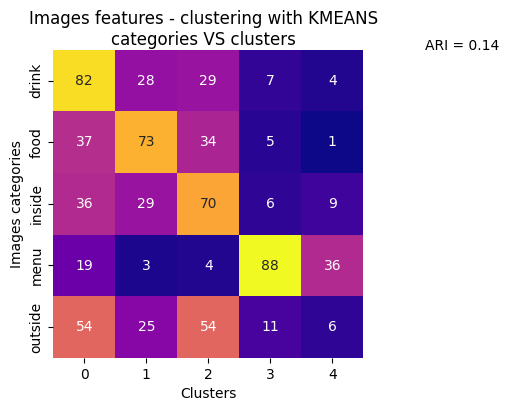

In [88]:
# use custom function to compute ARI and display a confusion matrix
mf.analyseCategoriesVSClusters(resultsDf=resultsSIFT)

Notre **ARI** est inférieur à 0.15, le résultat n'est **pas très bon**... Nous faisons à peine mieux qu'une segmentation aléatoire (ARI=0).

En revanche si nous regardons la matrice de confusion, on remarque que le résultat est **un peu plus intéressant pour la classe "menu"**, avec assez peu de faux-positifs et un nombre de faux-négatifs convenables. Cela peut se vérifier en calculant le f1-score pour chaque classe :

In [89]:
# display f1_score per class

# compute f1_score
f1s = np.round(
    f1_score(
        y_true=resultsSIFT["labelCode"], 
        y_pred=resultsSIFT["cluster"], 
        average=None
    ),2)

# put results in a dataframe
# store categories for columns names
cats = resultsSIFT["label"].cat.categories
# display in a dataframe
pd.DataFrame({cat : f1 for cat,f1 in zip(cats,f1s)}, index=["f1_score"])

drink  food  inside  menu  outside
f1_score   0.43  0.47    0.41  0.66     0.06

## CV-SIFT - 4.3) Représenter nos images et leurs catégories en 2D - T-SNE

Nous allons maintenant regarder **visuellement** ce qu'il se passe. Pour cela nous allons utiliser le **T-SNE** (t-distributed Stochastic Neighbor Embedding) qui est très populaire car cette technique de réduction de dimension permet de **bien représenter des données de (très) grande dimension en 2D** ou 3D.

Nous allons l'utiliser non pas sur nos features mais encore une fois **sur les composantes principales de notre ACP, afin que le T-SNE puisse bénéficier lui aussi d'un nombre réduit de dimensions**.

Cet algorithme étant lourd en temps de calcul, nous allons enregistrer le résultat :

In [90]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/TSNE"):
    os.mkdir("mySaves/TSNE")

Nous pouvons maintenant utiliser notre T-SNE :

In [91]:
%%time
# if no file in directory, run TSNE
if "siftFeatures_tnse.joblib" not in os.listdir("mySaves/TSNE") :
    # initiate TSNE with perplexity = 27 (sqrt(number of images)) and cosine metrics (better for images)
    tnse = openTSNE(
        n_components=2,
        perplexity=27,
        exaggeration=None,
        initialization="pca",
        metric="cosine",
        n_jobs=16,
        random_state=16
    )
    
    
    siftFeatures_tnse = pd.DataFrame(
        data=tnse.fit_transform(siftFeatures.values),
        columns=["tsneC1","tsneC2"]
    )

    # save
    dump(siftFeatures_tnse, "mySaves/TSNE/siftFeatures_tnse.joblib")


else :
    # load existing .joblib
    siftFeatures_tnse = load("mySaves/TSNE/siftFeatures_tnse.joblib")

CPU times: total: 0 ns
Wall time: 4.01 ms


Maintenant que nous avons réduit nos données sur un espace 2D, nous pouvons réaliser un scatterplot pour les représenter :
- par classe
- par cluster

In [92]:
# add categories and clusters to reducedPicsDf_tnse
siftFeatures_tnse["label"] = resultsSIFT["label"].values
siftFeatures_tnse["cluster"] = resultsSIFT["cluster"].values

Créons tout d'abord un dictionnaire de couleurs pour nos catégories :

In [93]:
# create a unique palette for both classes and clusters

# initiate a palette for classes
photoPalette = {
    "drink" : "deepskyblue",
    "food" : "gold",
    "inside" : "firebrick",
    "menu" : "lightgrey",
    "outside" : "forestgreen"
}

# add a duplicate with encodings as keys
photoPalette = photoPalette | {
    code : color for code, color in zip(resultsSIFT["labelCode"].cat.categories, photoPalette.values())
}

Nous pouvons maintenant tracer :

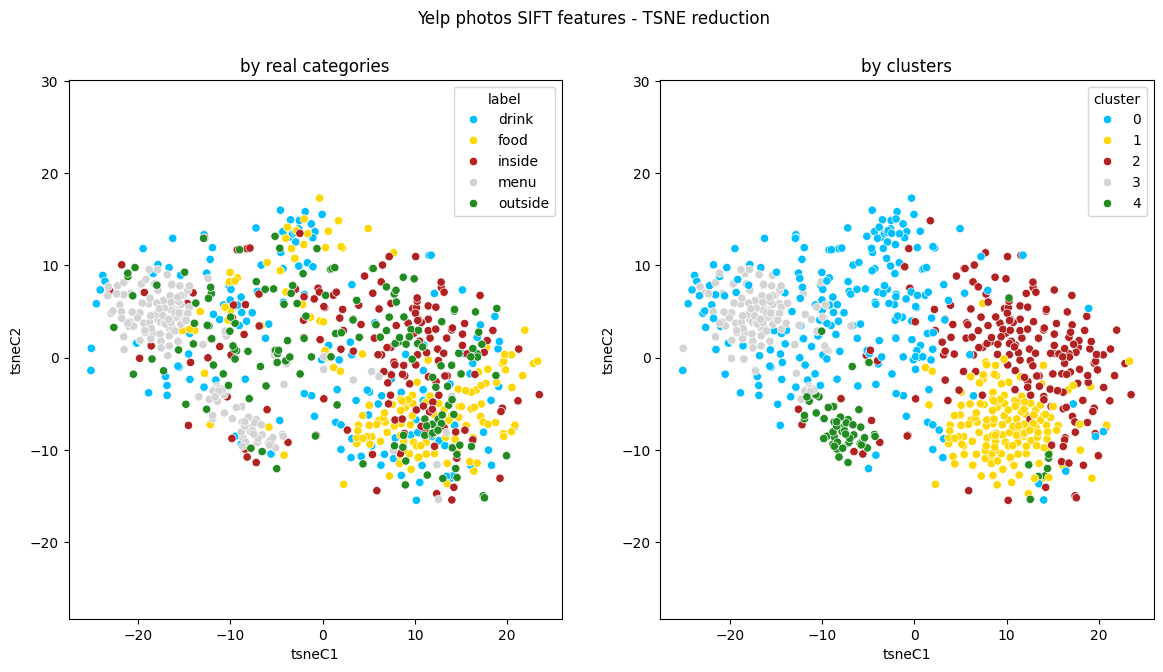

In [94]:
fig, (axLabel,axClust) = plt.subplots(1,2,figsize=(14,7))

# plot TSNE embedding with hue on categories
sns.scatterplot(data=siftFeatures_tnse, x="tsneC1", y="tsneC2", ax=axLabel, hue="label", palette=photoPalette)

# plot openTSNE
sns.scatterplot(data=siftFeatures_tnse, x="tsneC1", y="tsneC2", ax=axClust, hue="cluster",palette=photoPalette)

# titles
plt.suptitle("Yelp photos SIFT features - TSNE reduction")
axLabel.set_title("by real categories")
axClust.set_title("by clusters")

# scale
axLabel.axis("equal")
axClust.axis("equal")

plt.show()

Aparté - exporter cette représentation :

In [95]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/figures"):
    os.mkdir("mySaves/figures")

In [96]:
%%time
# if no files in directory, save
if "figSIFTscatter.joblib" not in os.listdir("mySaves/figures") :
    # save
    dump(fig, "mySaves/figures/figSIFTscatter.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


On retrouve bien notre résultat sur la catégorie "menu", qui est assez bien regroupée grâce à KMeans.

On peut afficher le **même graphique**, mais en **remplaçant les points par leurs images respectives**. Afin d'avoir un rendu digeste, nous allons n'en sélectionner que quelque-unes :

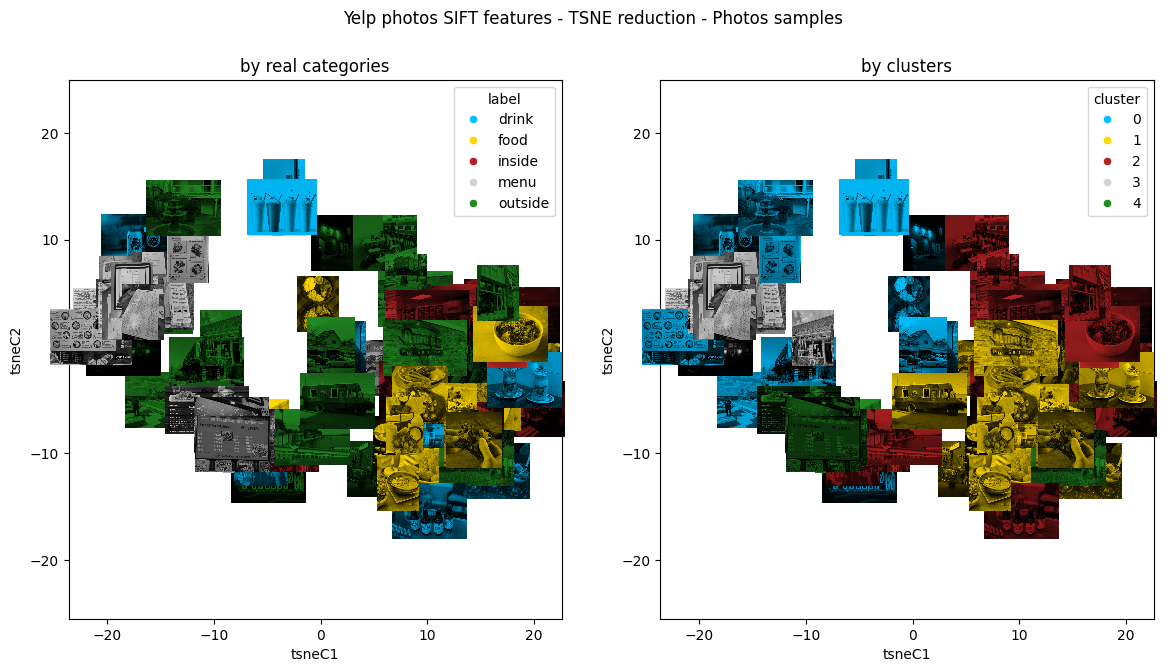

In [97]:
# plot on the same TSNE reduction but with images annotations

# sample (show only a limited number of images)
siftFeatures_tnse_samp = siftFeatures_tnse.sample(75, random_state=16)
idxSamp = siftFeatures_tnse_samp.index
# reset_index
siftFeatures_tnse_samp.reset_index(inplace=True,drop=True)
# use the same sampling on grayPhotos
grayPhotosSamp = [grayPhotos[i] for i in idxSamp]

# create a figure
fig, (axLabel,axClust) = plt.subplots(1,2,figsize=(14,7))

# transform photoPalette in rgb
paletteRgb = {k : to_rgb(v) for k,v in photoPalette.items()}

# scatterplots
# plot TSNE embedding with hue on categories
sns.scatterplot(data=siftFeatures_tnse_samp, x="tsneC1", y="tsneC2", ax=axLabel, hue="label", palette=paletteRgb)
# plot openTSNE
sns.scatterplot(data=siftFeatures_tnse_samp, x="tsneC1", y="tsneC2", ax=axClust, hue="cluster",palette=paletteRgb)

# create a function to annotate the plots with images
def addImageAnnotation(row):
    '''
    apply a color filter to the image (based on our paletteRgb) and add the image as to the plot
    parameter :
    -----------
    row - Series : a row of our TSNE dataframe
    output :
    --------
    add the image to each plot (clusters, labels), filtered with its corresponding color
    '''
    # get the index
    idx = row.name
    # get the corresponding image
    img = grayPhotosSamp[idx]
    # convert to rgb (for color filtering)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # create a image box for each axes :
    for ax, col in zip([axLabel,axClust],["label","cluster"]) :
        # get color from palette
        color = paletteRgb[row[col]]
        # apply color to image
        imgColored = img * color / 255
        # create OffsetImage instances
        imageBox = OffsetImage(
            imgColored, 
            zoom=0.1
        )

        # create annotation bbox
        annotBox = AnnotationBbox(
            offsetbox=imageBox, 
            xy=(row["tsneC1"], row["tsneC2"]),
            frameon=False
        )
        ax.add_artist(annotBox)

# Ajout des images aux points du scatterplot
siftFeatures_tnse_samp.apply(addImageAnnotation, axis=1)

# titles
plt.suptitle("Yelp photos SIFT features - TSNE reduction - Photos samples")
axLabel.set_title("by real categories")
axClust.set_title("by clusters")

# scale
axLabel.axis("equal")
axClust.axis("equal")

# save fig
if "figSIFTphotos.png" not in os.listdir("mySaves/figures") :
    plt.savefig("mySaves/figures/figSIFTphotos.png",bbox_inches='tight')

plt.show()

Le SIFT ne nous permet pas vraiment de conclure positivement quant à l'opportunité de développer un modèle de classification supervisée... Essayons maintenant avec du Transfer Learning :

# PARTIE II.B - ANALYSER LES PHOTOS POUR DÉTERMINER LES CATÉGORIES DES PHOTOS - TRANSFER LEARNING

Nous allons effectuer le même travail que précédemment, mais cette fois nous utiliserons un modèle CNN VGG16, pré-entraîné sur un (très) grand nombre d'images, comme un extracteur de features indépendant.

# CV-TL - 1,2,3) Utiliser un VGG16 pré-entraîné comme un extracteur de features autonome

Nous allons charger nos photos et **les préparer** pour le `VGG16` :
- les charger à la taille **224 x 224**
- les convertir en **arrays**
- les **rassembler** en un seul array
- les convertir en **BGR**
- **centrer** chaque canal de couleur

Ensuite nous utiliserons un `VGG16` déjà entraîné comme un extracteur de features. L'astuce consiste à **retirer la dernière couche fully-connected** (celle contenant la fonction d'activation Softmax nous donnant normalement nos scores par classe) et à **se servir de la sortie de la couche précédente** comme **features**.

In [98]:
# use custom function featureExtractorVGG16
VGG16featuresDf = mf.featureExtractorVGG16(photoData150["photo_path"].to_list())



24/24 [==============================] - 113s 5s/step


Voici donc nos features extraites du `VGG16` :

In [99]:
VGG16featuresDf

0         1         2         3         4         5         6     \
0    0.000000  0.000000  0.000000  0.000000  0.000000  1.344146  0.000000   
1    0.000000  1.529292  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.311633  0.000000  0.000000   
4    0.000000  0.000000  0.000000  0.000000  0.000000  1.362313  1.723081   
..        ...       ...       ...       ...       ...       ...       ...   
745  4.772371  2.135758  0.000000  0.297902  0.000000  1.508706  0.000000   
746  0.000000  0.000000  0.000000  0.000000  0.227945  0.263670  0.000000   
747  1.079931  2.709269  3.142630  0.000000  0.920520  2.248486  0.000000   
748  0.000000  0.000000  2.207755  0.000000  0.141740  0.583092  0.000000   
749  1.000865  2.079030  0.000000  0.000000  0.000000  1.795846  0.000000   

         7         8     9     ...      4086      4087      4088      4089  \
0    0.000000  2.987560   0.0  ...  0.043387  0.314660  0.000000  2.291917   
1    0.000000  3.359872   0.0  ...  0.000000  0.000000  0.000000  0.139604   
2    0.000000  0.000000   0.0  ...  0.801694  2.342701  0.000000  0.000000   
3    0.000000  1.069143   0.0  ...  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.000000   0.0  ...  0.000000  7.172790  0.000000  0.000000   
..        ...       ...   ...  ...       ...       ...       ...       ...   
745  0.000000  1.476988   0.0  ...  0.000000  0.000000  1.310945  0.000000   
746  4.905649  0.000000   0.0  ...  0.000000  1.396181  0.000000  0.000000   
747  0.000000  0.000000   0.0  ...  0.648024  0.000000  0.000000  0.000000   
748  2.062076  1.076050   0.0  ...  0.000000  0.000000  0.000000  0.000000   
749  4.118852  2.185182   0.0  ...  0.000000  0.000000  0.000000  0.000000   

     4090      4091      4092      4093      4094      4095  
0     0.0  5.902059  0.000000  0.000000  0.000000  0.000000  
1     0.0  3.228852  0.000000  0.000000  0.000000  0.000000  
2     0.0  2.004656  1.457198  0.000000  0.473861  0.000000  
3     0.0  2.553883  1.697834  0.000000  0.000000  0.000000  
4     0.0  0.000000  2.883827  0.000000  0.000000  1.979372  
..    ...       ...       ...       ...       ...       ...  
745   0.0  0.000000  1.865705  0.000000  1.977765  0.000000  
746   0.0  0.000000  1.978556  2.342378  0.000000  0.281457  
747   0.0  0.000000  1.329357  0.000000  0.205301  0.000000  
748   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
749   0.0  0.000000  1.488916  0.000000  0.324818  0.000000  

[750 rows x 4096 columns]

# CV-TL - 4) Éprouver la faisabilité - clustering et représentation dans un espace réduit

Nous pouvons maintenant réaliser les même étapes que précédemment :

## CV-TL - 4.1) PCA

Réduction de dimension par ACP :

In [100]:
# custom function myPCA for dimensionality reduction
_, reducedVGG16featuresDf = mf.myPCA(df=VGG16featuresDf, n_components=0.99)

In [101]:
reducedVGG16featuresDf

C0         C1         C2         C3         C4         C5  \
0    -0.846844 -11.891648  -6.117409  -0.321531  -4.291314 -10.926962   
1     5.037038 -13.103476 -21.579847  -3.339196  17.819542  -8.520999   
2     9.072470 -11.708893  -6.724623   3.355147  -4.021973  -4.834325   
3     7.830358 -15.519655  -2.015347  -5.825788  -3.770976  -4.440274   
4     9.490546 -11.651084 -16.992376  10.883782   5.122123  -1.121017   
..         ...        ...        ...        ...        ...        ...   
745 -16.692192  -3.265703   8.305226  -0.597685   2.250105  -0.669502   
746 -21.897051   3.863276  19.063555  17.120140   2.947695   0.455648   
747 -22.948318  -3.751244  14.161911   5.887484  -6.787970 -16.807749   
748  -5.360376  -6.883368   3.313619  -0.890332  -5.240020   4.500562   
749 -20.396406  -1.092748  12.486360   6.833589   4.355176  -3.832265   

            C6         C7         C8         C9  ...      C658      C659  \
0     6.937275  -4.013062   1.305456  -6.764220  ...  0.275992  0.232448   
1     8.204868 -10.765575   9.014996   3.520704  ...  0.055824 -0.086650   
2     3.494398 -10.439291   1.280555  -3.690864  ...  0.361386  0.752341   
3    -0.899712   2.694331  -7.181766   2.515010  ... -1.738478  0.746993   
4    -1.717757   4.987013  -8.951239   3.050794  ... -0.412995  0.353915   
..         ...        ...        ...        ...  ...       ...       ...   
745   2.502978   6.067108  13.828718  -2.058380  ...  1.354451  0.674890   
746  -7.644177   8.272277 -10.308487   6.402967  ... -1.173476  0.004113   
747  16.557098  13.813929 -10.116401   2.190849  ... -0.717080 -0.321879   
748  19.392698   4.678575 -11.867173  25.445969  ...  0.773658 -0.563198   
749  -0.639934   3.972379   4.758766  14.303267  ...  0.423969 -0.625897   

         C660      C661      C662      C663      C664      C665      C666  \
0    0.458625  0.543959  0.558122  0.222823 -0.290006 -0.539147  0.441321   
1    0.150906 -0.264959 -0.387549 -0.202632  0.066685  0.056771  0.600771   
2    1.039569 -0.582764  1.270338 -0.051740 -0.014589 -0.750147 -0.315649   
3   -0.229166  0.235357  1.069663  1.198710 -1.320364 -0.212584  1.796925   
4   -0.452754  0.155670  0.352397 -0.223602  0.204227 -0.338269 -0.314110   
..        ...       ...       ...       ...       ...       ...       ...   
745 -0.447962 -0.068523  0.513905  1.289415  0.007132  0.686439  0.755732   
746 -0.166067  0.161276  0.581105 -0.153876  0.496190 -0.710089  0.551572   
747  0.160348 -0.334544 -1.048383  0.455517  0.471570  0.863461 -0.557380   
748  0.248257  0.153649  0.176953  0.101077  0.064154 -0.137383 -0.173484   
749  0.875829  0.002161  1.905202  0.037114  0.323765  0.278499  2.208125   

         C667  
0   -0.017980  
1    0.214744  
2   -0.322518  
3   -0.859026  
4    0.486111  
..        ...  
745  0.022184  
746  0.497732  
747 -0.151075  
748  0.014598  
749 -0.138965  

[750 rows x 668 columns]

Aparté - exporter le dataframe `reducedVGG16featuresDf` :

In [102]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/transferLearningFeatures"):
    os.mkdir("mySaves/transferLearningFeatures")

In [103]:
%%time
# if no files in directory, save
if "reducedVGG16featuresDf.joblib" not in os.listdir("mySaves/transferLearningFeatures") :
    # save
    dump(reducedVGG16featuresDf, "mySaves/transferLearningFeatures/reducedVGG16featuresDf.joblib")

CPU times: total: 0 ns
Wall time: 1.63 ms


## CV-TL - 4.2) Clustering - KMeans et interprétation

Appliquons maintenant notre algorithme de clustering avec, pour rappel, K = le nombre catégories de photo :

In [104]:
# use custom function compareCategoriesVSKmeans to apply Kmeans on our PCA reduction
resultsVGG16 = mf.compareCategoriesVSKmeans(imageFeaturesDf=reducedVGG16featuresDf, catSeries=photoData150["label"])
resultsVGG16

label labelCode  cluster
0      drink         0        0
1      drink         0        0
2      drink         0        0
3      drink         0        0
4      drink         0        0
..       ...       ...      ...
745  outside         4        4
746  outside         4        4
747  outside         4        4
748  outside         4        2
749  outside         4        4

[750 rows x 3 columns]

Regardons ce que donnent l'**ARI** et la **matrice de confusion** :

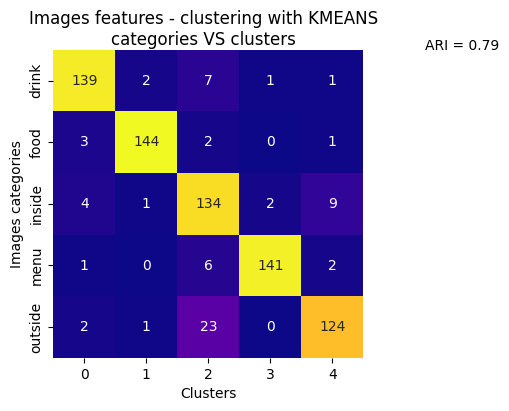

In [105]:
# use custom function to compute ARI and display a confusion matrix
mf.analyseCategoriesVSClusters(resultsDf=resultsVGG16)

Notre **ARI est au dessus de 0.70**, le résultat est **bien plus encourageant**.

Toutes les classes sont assez bien regroupées. Seul bémol, la classe "inside" semble attirer plus de faux-positifs. Cela peut se vérifier en calculant la précision pour chaque classe :

In [106]:
# display precision per class

# compute precision
precisions = np.round(
    precision_score(
        y_true=resultsVGG16["labelCode"], 
        y_pred=resultsVGG16["cluster"], 
        average=None
    ),2)

# put results in a dataframe
# store categories for columns names
cats = resultsVGG16["label"].cat.categories
# display in a dataframe
pd.DataFrame({cat : pr for cat,pr in zip(cats,precisions)}, index=["precision"])

drink  food  inside  menu  outside
precision   0.93  0.97    0.78  0.98     0.91

## CV-TL - 4.3) Représenter nos images et leurs catégories en 2D - T-SNE

Comme précédemment, nous utilison T-SNE pour représenter nos données en 2D :

In [107]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/TSNE"):
    os.mkdir("mySaves/TSNE")

Nous pouvons maintenant utiliser notre T-SNE :

In [108]:
%%time
# if no file in directory, run TSNE
if "reducedVGG16featuresDf_tnse.joblib" not in os.listdir("mySaves/TSNE") :
    # initiate TSNE with perplexity = 27 (sqrt(number of images)) and cosine metrics (better for images)
    tnse = openTSNE(
        n_components=2,
        perplexity=27,
        exaggeration=None,
        initialization="pca",
        metric="cosine",
        n_jobs=16,
        random_state=16
    )
    
    
    reducedVGG16featuresDf_tnse = pd.DataFrame(
        data=tnse.fit_transform(reducedVGG16featuresDf.values),
        columns=["tsneC1","tsneC2"]
    )

    # save
    dump(reducedVGG16featuresDf_tnse, "mySaves/TSNE/reducedVGG16featuresDf_tnse.joblib")


else :
    # load existing .joblib
    reducedVGG16featuresDf_tnse = load("mySaves/TSNE/reducedVGG16featuresDf_tnse.joblib")

CPU times: total: 0 ns
Wall time: 12.2 ms


Maintenant que nous avons réduit nos données sur un espace 2D, nous pouvons réaliser un scatterplot pour les représenter :
- par classe
- par cluster

In [109]:
# add categories and clusters to reducedPicsDf_tnse
reducedVGG16featuresDf_tnse["label"] = resultsVGG16["label"].values
reducedVGG16featuresDf_tnse["cluster"] = resultsVGG16["cluster"].values

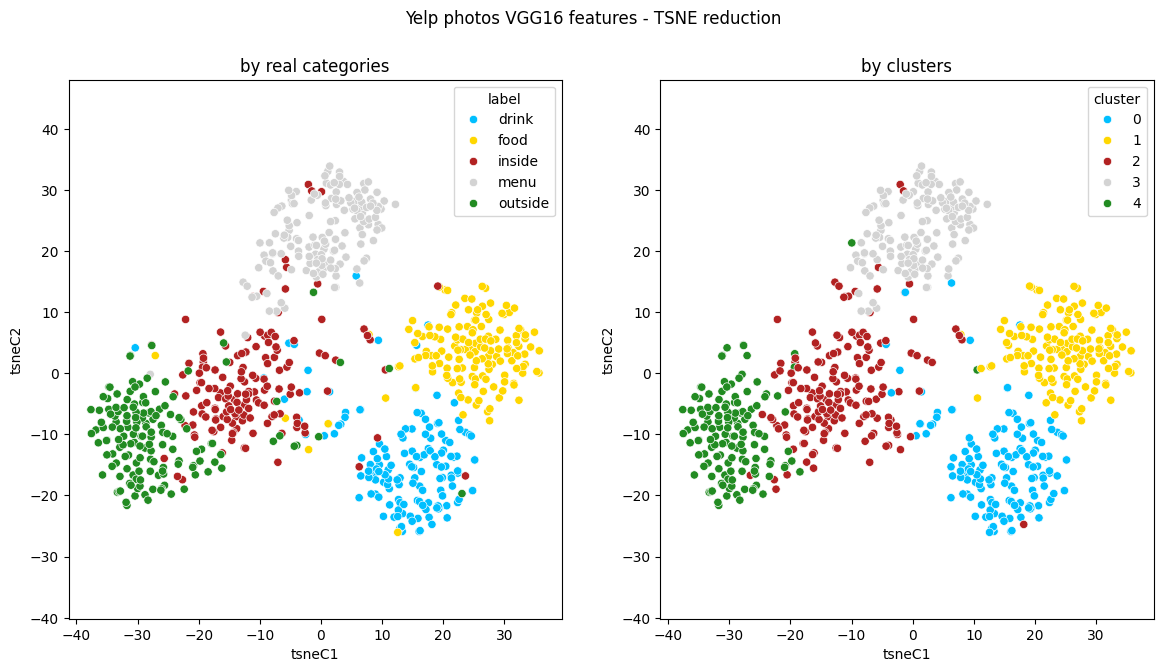

In [110]:
fig, (axLabel,axClust) = plt.subplots(1,2,figsize=(14,7))

# plot TSNE embedding with hue on categories
sns.scatterplot(data=reducedVGG16featuresDf_tnse, x="tsneC1", y="tsneC2", ax=axLabel, hue="label", palette=photoPalette)

# plot openTSNE
sns.scatterplot(data=reducedVGG16featuresDf_tnse, x="tsneC1", y="tsneC2", ax=axClust, hue="cluster",palette=photoPalette)

# titles
plt.suptitle("Yelp photos VGG16 features - TSNE reduction")
axLabel.set_title("by real categories")
axClust.set_title("by clusters")

# scale
axLabel.axis("equal")
axClust.axis("equal")

plt.show()

Aparté - exporter cette représentation :

In [111]:
%%time
# if no files in directory, save
if "figTLscatter.joblib" not in os.listdir("mySaves/figures") :
    # save
    dump(fig, "mySaves/figures/figTLscatter.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


Comme précédemment, nous pouvons aussi **afficher nos quelques images dans l'espace réduit** :

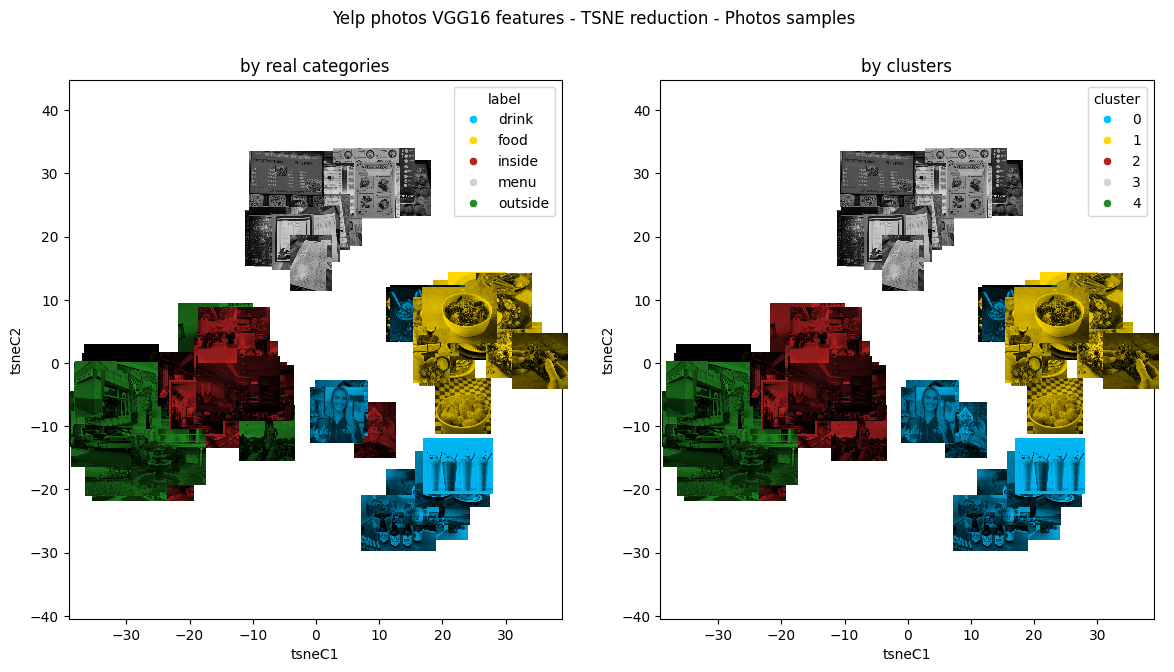

In [112]:
# plot on the same TSNE reduction but with images annotations

# use the same photos sample
reducedVGG16featuresDf_tnse_samp = reducedVGG16featuresDf_tnse.loc[idxSamp].reset_index(drop=True)

# create a figure
fig, (axLabel,axClust) = plt.subplots(1,2,figsize=(14,7))

# scatterplots
# plot TSNE embedding with hue on categories
sns.scatterplot(data=reducedVGG16featuresDf_tnse_samp, x="tsneC1", y="tsneC2", ax=axLabel, hue="label", palette=paletteRgb)
# plot openTSNE
sns.scatterplot(data=reducedVGG16featuresDf_tnse_samp, x="tsneC1", y="tsneC2", ax=axClust, hue="cluster",palette=paletteRgb)

# Ajout des images aux points du scatterplot
reducedVGG16featuresDf_tnse_samp.apply(addImageAnnotation, axis=1)

# titles
plt.suptitle("Yelp photos VGG16 features - TSNE reduction - Photos samples")
axLabel.set_title("by real categories")
axClust.set_title("by clusters")

# scale
axLabel.axis("equal")
axClust.axis("equal")

# save fig
if "figTLphotos.png" not in os.listdir("mySaves/figures") :
    plt.savefig("mySaves/figures/figTLphotos.png",bbox_inches='tight')

plt.show()

**Le VGG16 en tant qu'extracteur de features donne de bien meilleurs résultats.**

On peut **conclure** qu'il serait **opportun de poursuivre le projet** avec le **développement d'un modèle de classification supervisée** (avec bien plus de photos).

# PARTIE III - COLLECTER UN ÉCHANTILLON DE DONNÉES (ENVIRON 200 RESTAURANTS ET LEURS REVUES) VIA L’API YELP

Pour rappel l'objectif ici est de s'assurer de la **possibilité** de collecter des nouvelles données. Pour cela nous réalisons un test en utilisant l'**API Yelp** pour récupérer :
- l'ID de **200 restaurants** tous situés dans **la même ville**
- les **commentaires** clients associés.

Nous stockerons les résultats dans un CSV.

# API - 1) Méthode

Afin d'utiliser l'API de Yelp nous avons créé un compte pour obtenir un **identifiant client** ainsi que la **clé API** associée.

Nous utiliserons le langage de requête **GraphQL** promu par Yelp pour :
- sa flexibilité,
- le contrôle sur le contenu des réponses
- la personnalisation des requêtes. C'est le client qui décide de ce qu'il veut récupérer

Pour résumer le **client utilisant GraphQL récupère exactement ce qu'il demande au serveur, sans surplus de données inutiles**.

Afin d'utiliser l'API Yelp spécifique pour GraphQL, nous nous sommes inscrits au *Developer Beta program*.

# API - 2) Imports

Nous utiliserons la librairie gql qui est un client GraphQL pour python. <br>
*Nota : Nous suivrons la méthode décrite dans le tutorial de **Sigma Coding**   : https://www.youtube.com/watch?v=Wdy-9daEd0o&ab_channel=SigmaCoding*

In [113]:
# GraphQL query client : gql
from gql import gql
# Client to interface with the server
from gql import Client
# RequestsHTTPTransport 
from gql.transport.requests import RequestsHTTPTransport
# json for storing and reading te API credentials
import json
# for folders management
import os  
# pandas for CSV export
import pandas as pd

# API - 3) Préparation

## API - 3.0) Création d'un dossier pour stocker notre CSV

In [114]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/apiTest"):
    os.mkdir("mySaves/apiTest")

## API - 3.1) Création d'un fichier de configuration pour stocker / lire les identifiants de l'API

Comme préconisé sur le site de Yelp (https://docs.developer.yelp.com/docs/fusion-authentication), le `client_id` et la clé de l'`API_key` restent personnels :

In [115]:
# # create a json config file to store API credentials
# config = {
#     "API Key" : "xxx"
# }

# # create 
# with open("config.json", "w+") as f :
#     json.dump(config, f)

In [116]:
# read json config file to get Yelp API credentials
with open("config.json", "r") as f :
    config = json.load(f)

API_key = config["API Key"]

## API - 3.2) Définition des en-têtes HTTP

`gql` envoie des en-têtes HTTP contenant notamment la clé API pour pouvoir utiliser les serveurs Yelp. Nous y spécifions également que les requêtes seront envoyées sous format `json`.

In [117]:
# define HTTP headers with our API_key and specifying we will sent queries in json format
myHeaders = {
    "Authorization" : "bearer "+API_key,
    "Content-Type" : "application/json"
}

## API - 3.3) Contruction du client

Nous définissons d'abord le transport HTTP qui permettra d'envoyer la requête GraphQL, puis le client lui-même :

In [118]:
# define transport
myTransport =  RequestsHTTPTransport(
    url="https://api.yelp.com/v3/graphql",
    headers=myHeaders,
    use_json=True,
    
)

# create the client
myClient = Client(transport=myTransport, fetch_schema_from_transport=True)

## API - 3.4) Requêtes et sauvegarde dans un CSV

Nous allons pouvoir envoyer nos requêtes.

En voici les caractéristiques :
- point de terminaison : *businesses/search*, qui permet l'utilisation de filtres
- paramètres de recherche :
    - `location` : "santa barbara". Pour le test nous nous concentrons sur une seule ville
    - `term` : "restaurants"
    - `limit` : ~~200~~ ... Nous sommes malheureusement limités à **50**... Nous utiliserons donc **une boucle pour pouvoir récupérer notre échantillon complet**
    - `offset` : **0, 50, 100 ou 150**. Au sein d'une itération, ce paramètre permettra de récupérer 50 établissements **à la suite** des 50 précédents, donnant ainsi l'occasion de contourner la limitation à 50 établissements
- champs *business* à récupérer :
    - `id`
    - `reviews` (nombre **limité à 3**) :
        - `rating`
        - `text`
    - `name`

Pour nous aider à la rédaction, nous utilisons l'outil mis à disposition par Yelp : https://docs.developer.yelp.com/graphql/

In [119]:
# query names, ids and reviews for 200 restaurants 

# if the csv is not already saved
if "samplesDf.csv" not in os.listdir("mySaves/apiTest") :

    # initiate a dataframe to store results
    samplesDf = pd.DataFrame(columns=["restaurant_name","restaurant_id","review_rating","review_text"])
    
    # iterate on values of offset
    for o in [0, 50, 100, 150] :
        # create a query
        query = gql('''
        {
            search(
                limit: 50, 
                offset: '''+str(o)+''', 
                location: "santa barbara", 
                term: "restaurants")
                {
                    business {
                        id
                        reviews {
                            rating
                            text
                        }
                    name
                    }
                }
        }
        ''')
        
        # execute query
        results = myClient.execute(query)
        # extract infos from results
        results = results["search"]["business"]
    
        # add infos to our dataframe
    
        # first iterate on each business
        for businessDict in results :
            for reviewsDict in businessDict["reviews"] :
                row = [businessDict["name"],businessDict["id"],reviewsDict["rating"],reviewsDict["text"]]
                samplesDf.loc[len(samplesDf)]=row

    # store dataframe in a CSV
    samplesDf.to_csv(
        path_or_buf = "mySaves/apiTest/samplesDf.csv",
        index=False
    )

# else, just load the csv
else :
    samplesDf = pd.read_csv("mySaves/apiTest/samplesDf.csv")

Voici le résultat :

In [120]:
samplesDf

restaurant_name           restaurant_id  review_rating  \
0                   Santo Mezcal  nYPzsOjvida-ne7swSPHpA              5   
1                   Santo Mezcal  nYPzsOjvida-ne7swSPHpA              5   
2                   Santo Mezcal  nYPzsOjvida-ne7swSPHpA              5   
3    Brophy Bros - Santa Barbara  U3grYFIeu6RgAAQgdriHww              5   
4    Brophy Bros - Santa Barbara  U3grYFIeu6RgAAQgdriHww              5   
..                           ...                     ...            ...   
592     Oak Park Market + Eatery  LMm555z8BReDxgkpF_TEug              4   
593     Oak Park Market + Eatery  LMm555z8BReDxgkpF_TEug              4   
594                    Su’s Bowl  MiMRlsXOpHJMSTDAuw8s1w              5   
595                    Su’s Bowl  MiMRlsXOpHJMSTDAuw8s1w              5   
596                    Su’s Bowl  MiMRlsXOpHJMSTDAuw8s1w              5   

                                           review_text  
0    This was my first time here and I was beyond i...  
1    Santo Mezcal is a beautiful restaurant in the ...  
2    Such a delicious dinner location. Thankfully w...  
3    Excellent setting and view --  fantastic food ...  
4    Amazing place! This bar/restaurant is located ...  
..                                                 ...  
592  I was excited that everything wasn't priced ve...  
593  This place is pretty good. I got a chocolate p...  
594  Very good chicken fried rice and xiao long bao...  
595  Fulfilled my craving for good asian food! The ...  
596  I always doordash from here, but I decided to ...  

[597 rows x 4 columns]

Il n'y a pas 200 restaurants x 3 commentaires = 600 lignes... Certains restaurants n'ont peut-être pas assez de reviews :

In [121]:
# search for restaurants with less than 3 reviews

# groupby "restaurant_id"
gb = samplesDf.groupby("restaurant_id").count()["review_rating"]

# filter and keep ids
mask = gb < 3
ids = gb.loc[mask].index

# display these restaurants
samplesDf.loc[samplesDf["restaurant_id"].isin(ids)]

restaurant_name           restaurant_id  review_rating  \
330      Cafe La Fonda  biYAISHrXnuQ-nGdoZ6xKQ              5   
331      Cafe La Fonda  biYAISHrXnuQ-nGdoZ6xKQ              5   
563  Cheverez Seafoods  0ffKmdFmcIrv6TIN05oQvQ              5   

                                           review_text  
330  Good food quick service really liked their sal...  
331  Food was delicious salsas were unique the wait...  
563  Santa Barbara News Press published an article ...